# Import Library

In [ ]:
import numpy as np
import pandas as pd
import csv
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import torch.nn.functional as F
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

device = "cuda" if torch.cuda.is_available() else "cpu"

# PreProcess Data

## Read Data

In [138]:
data = pd.read_csv("data.csv")

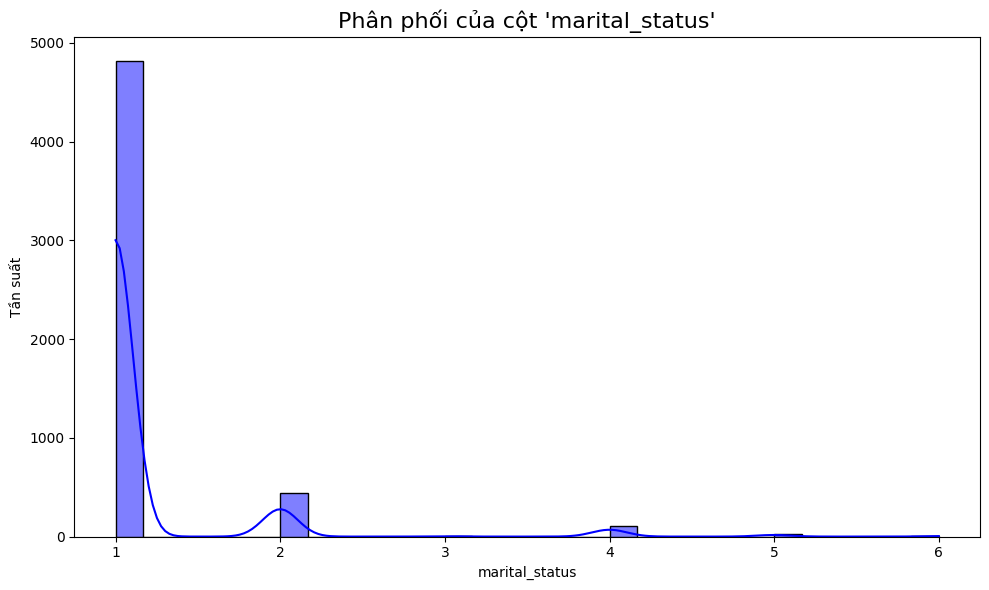

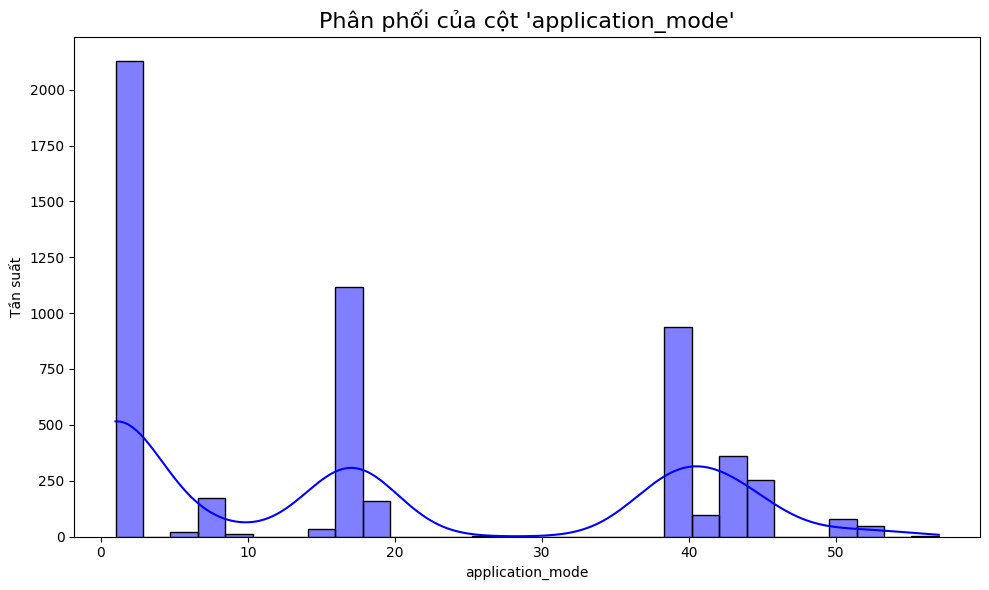

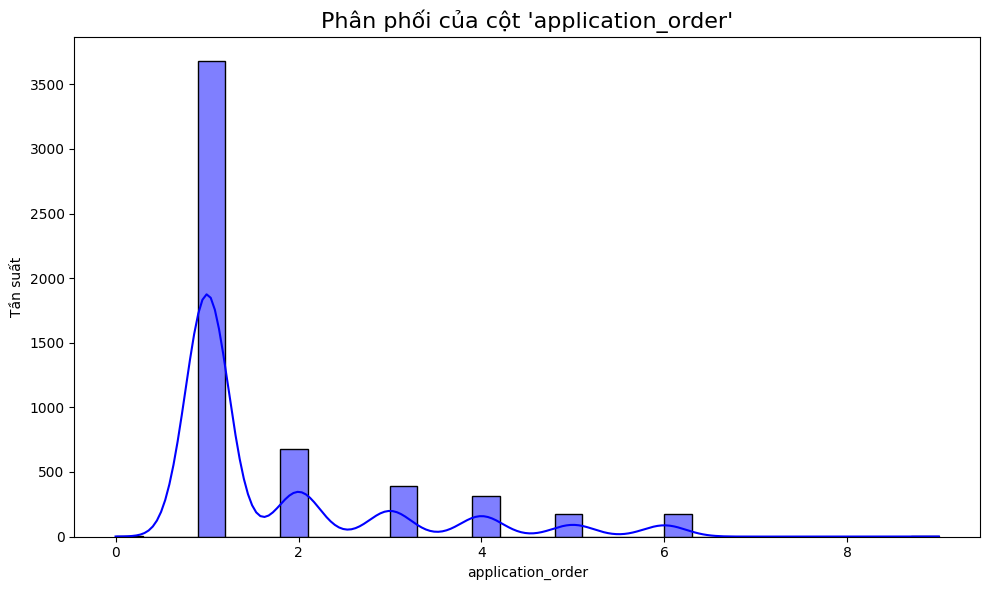

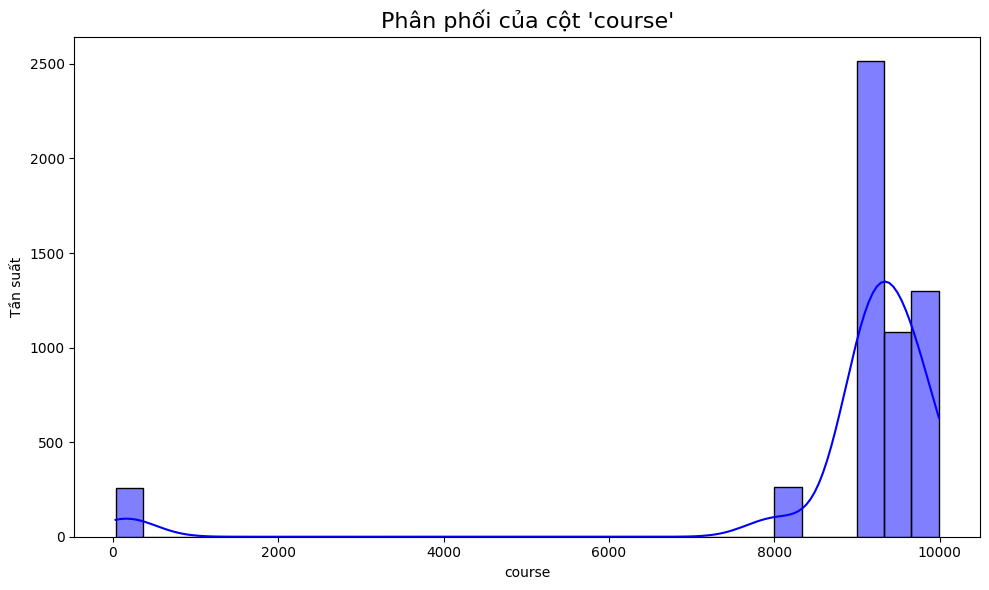

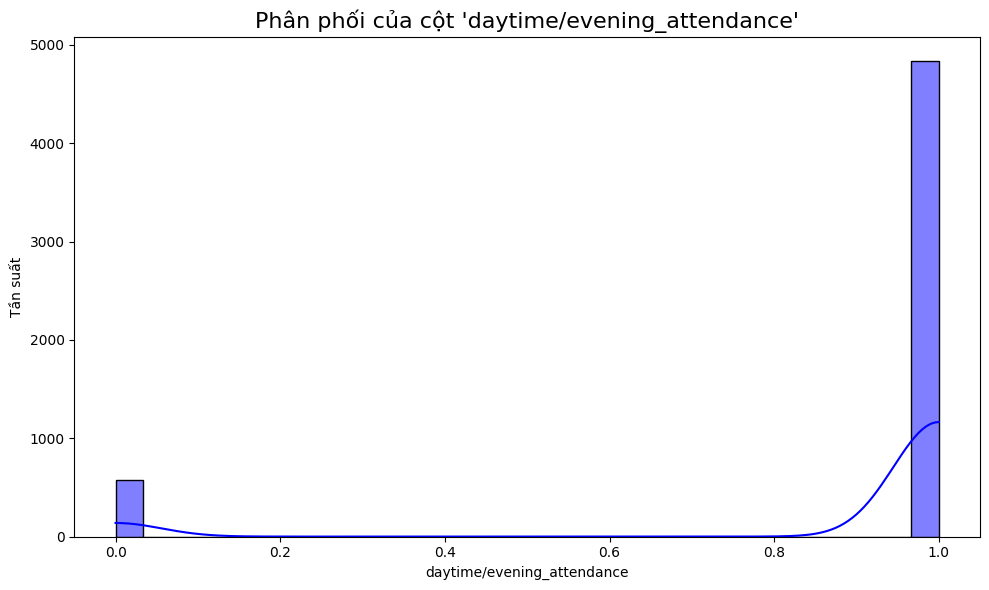

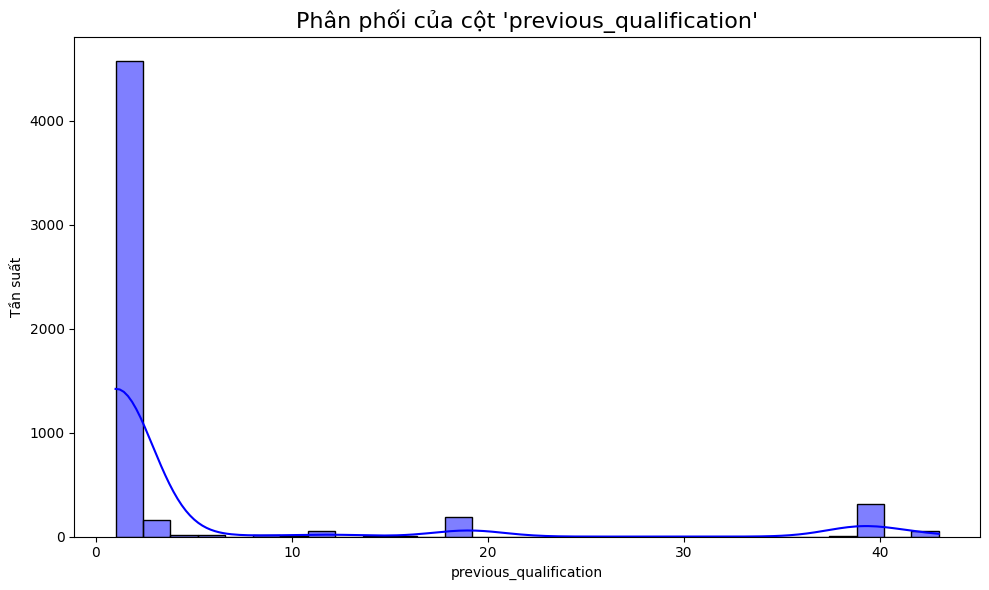

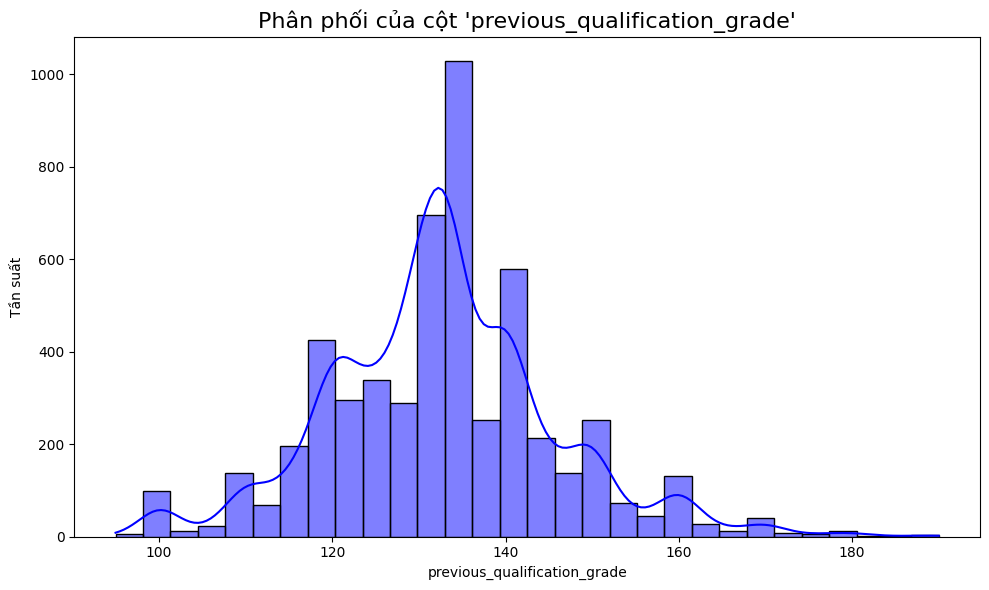

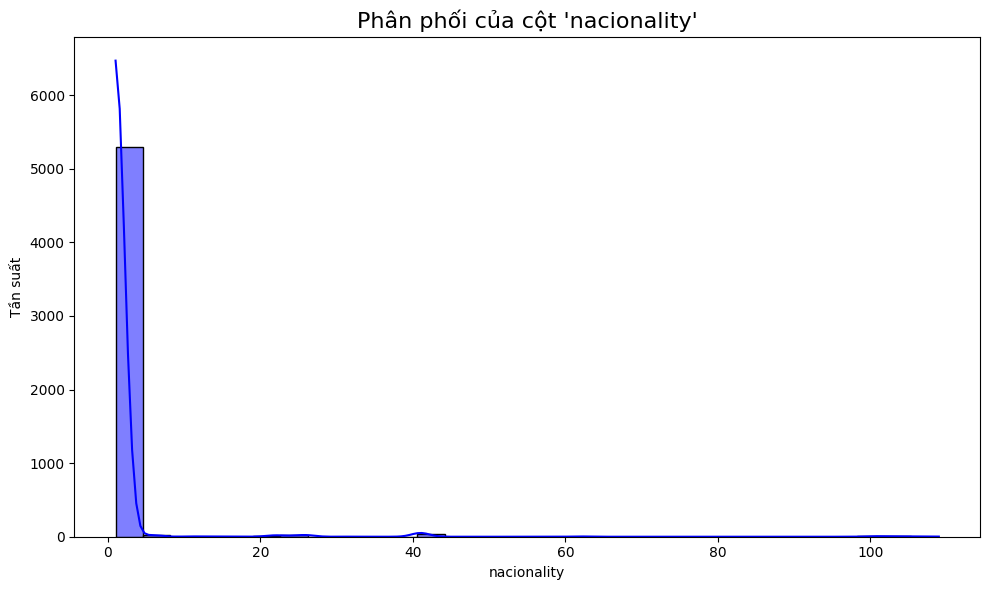

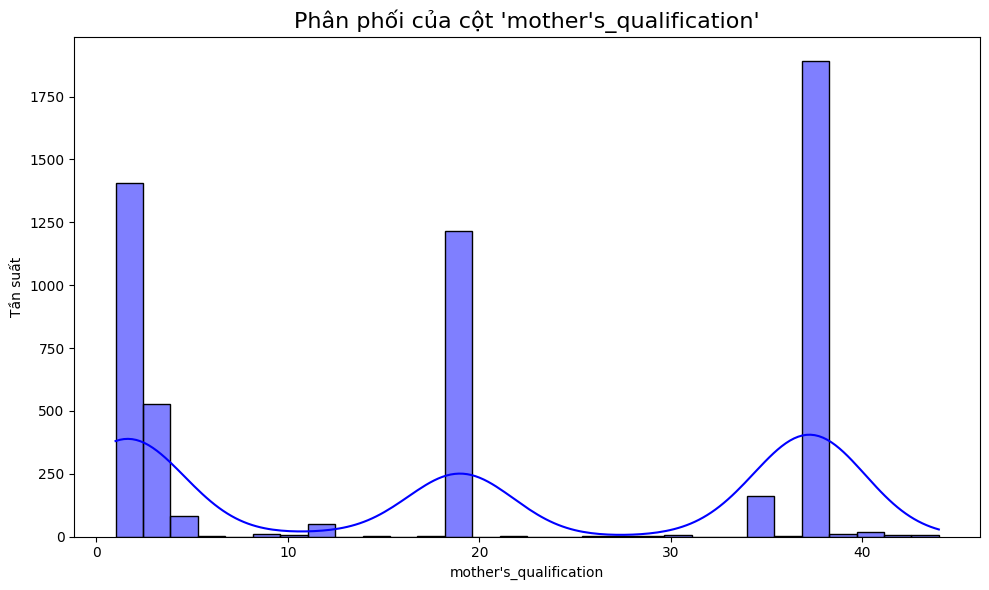

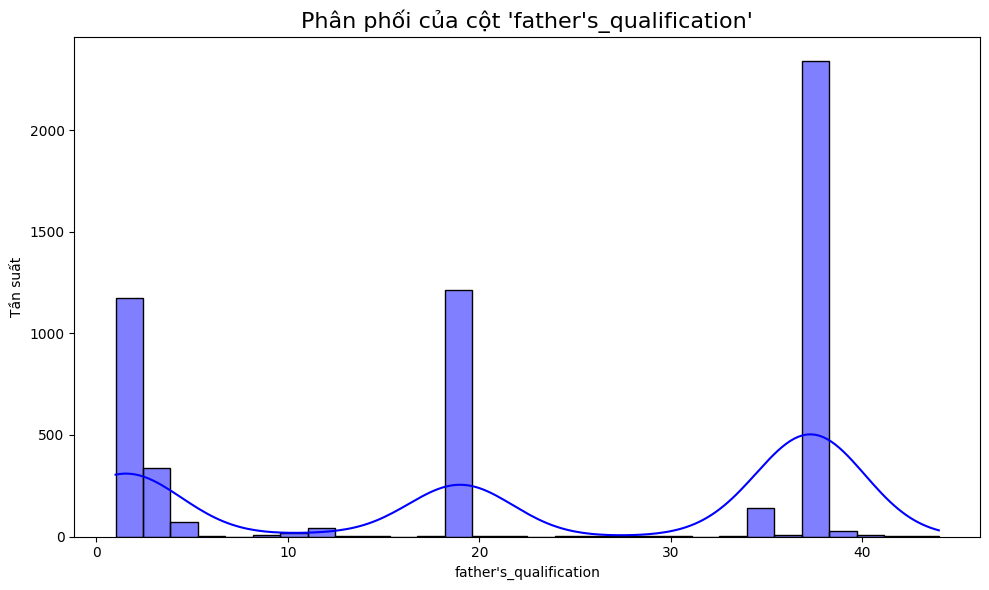

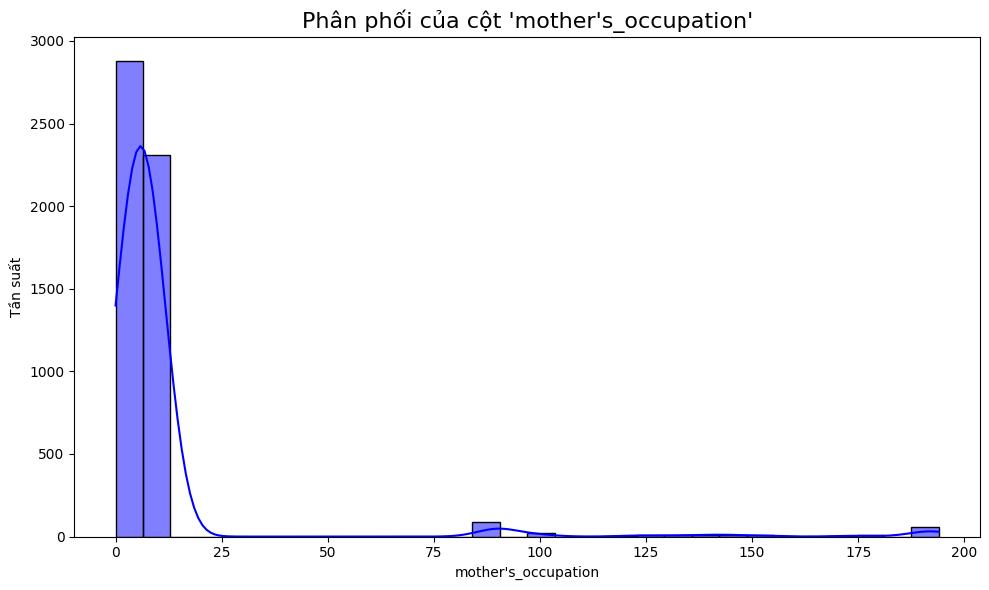

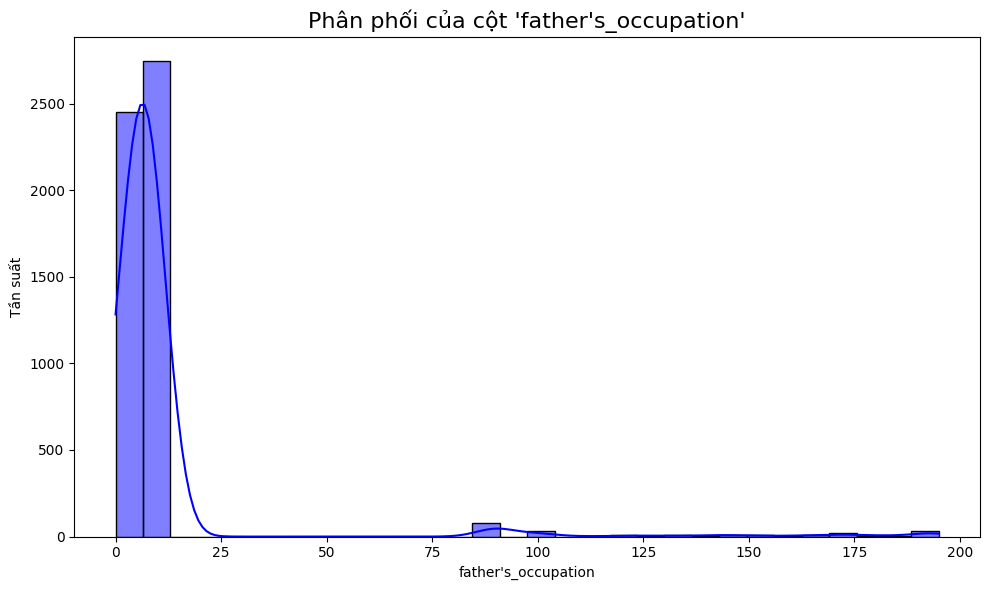

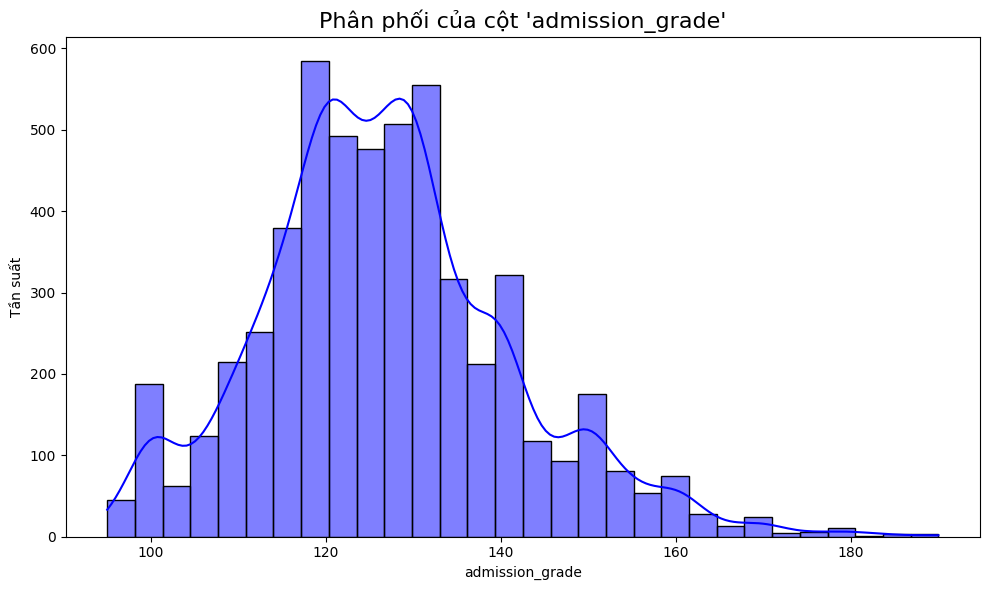

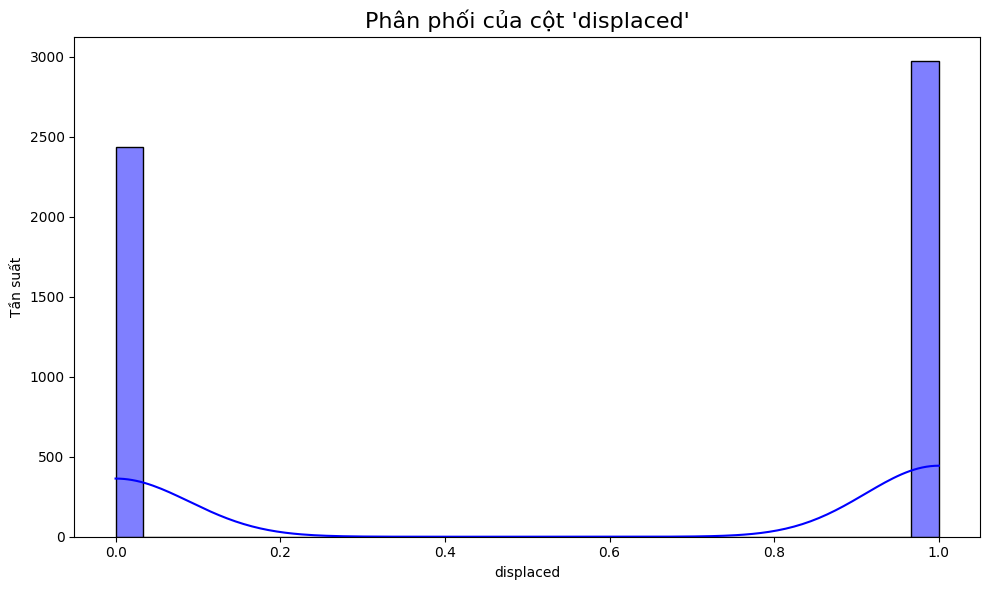

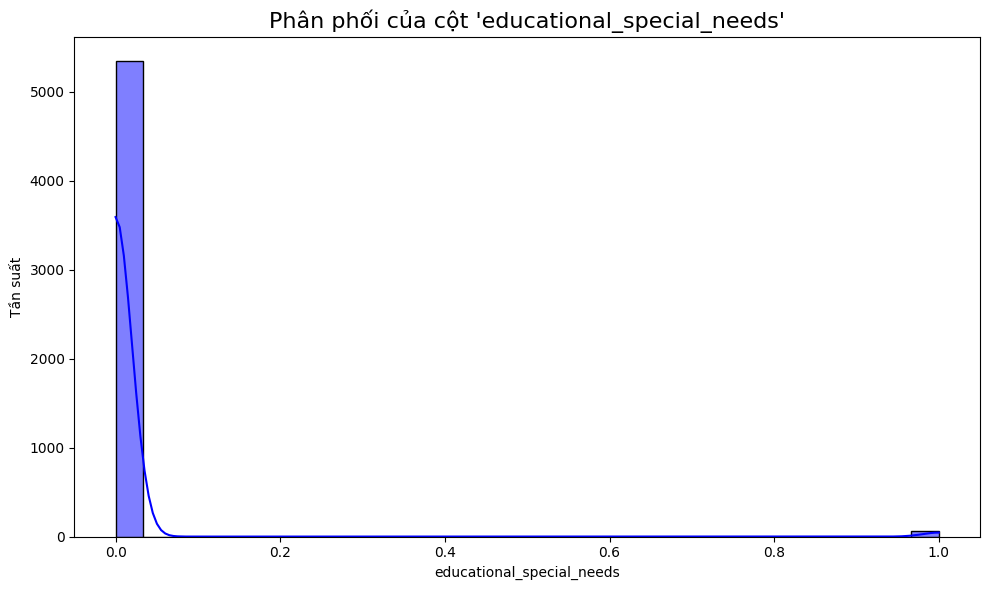

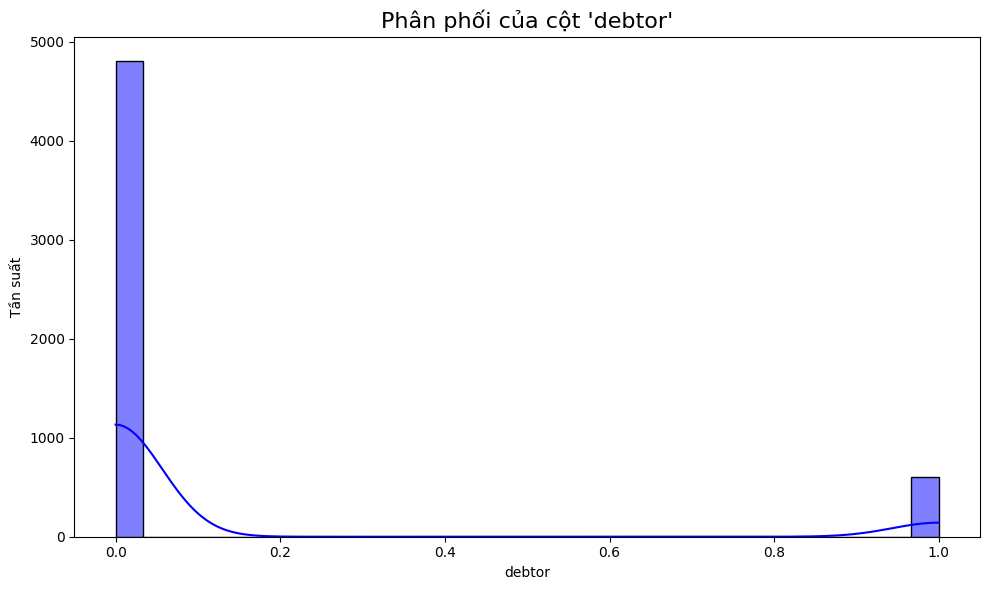

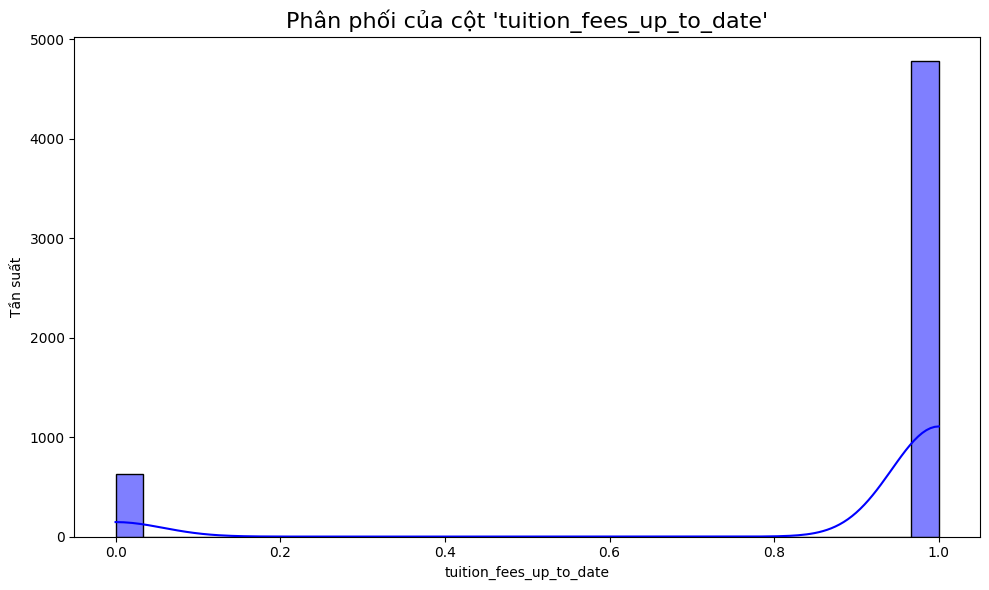

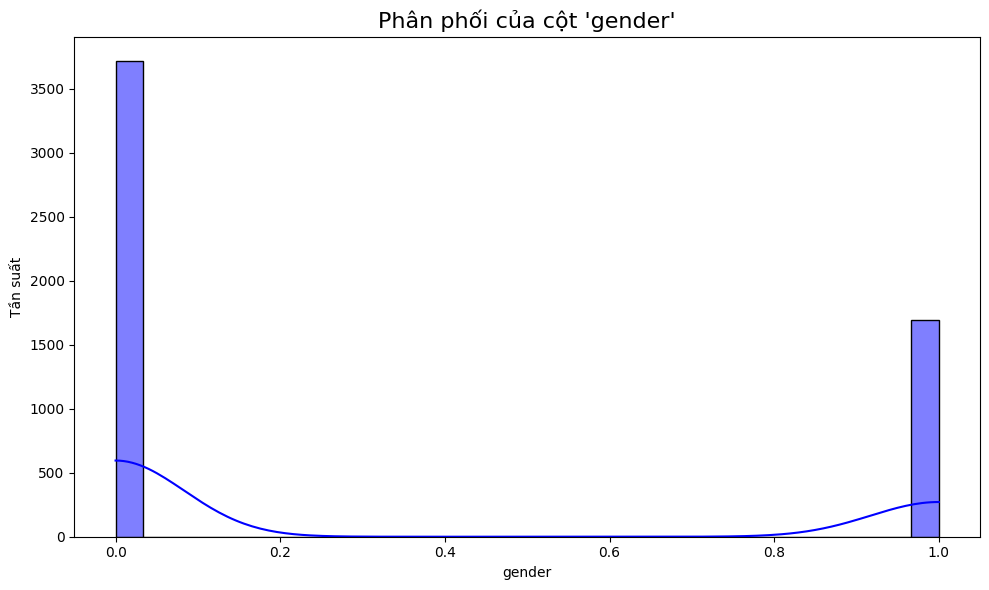

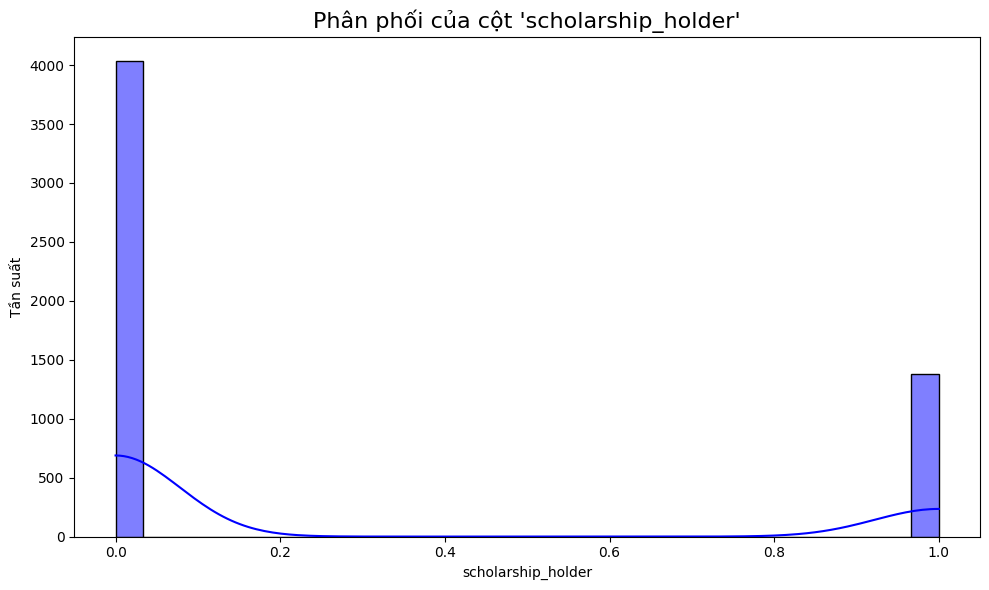

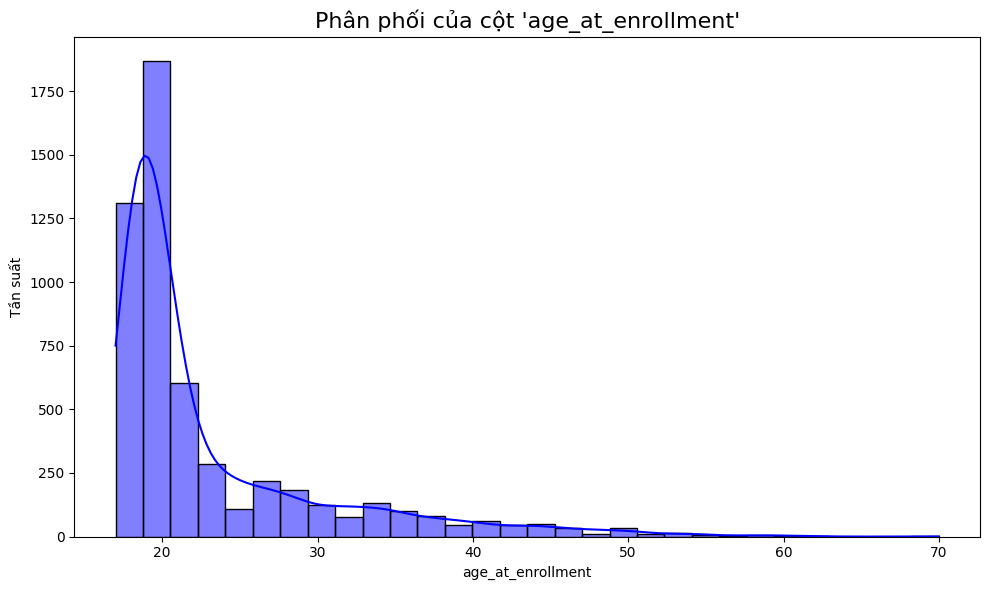

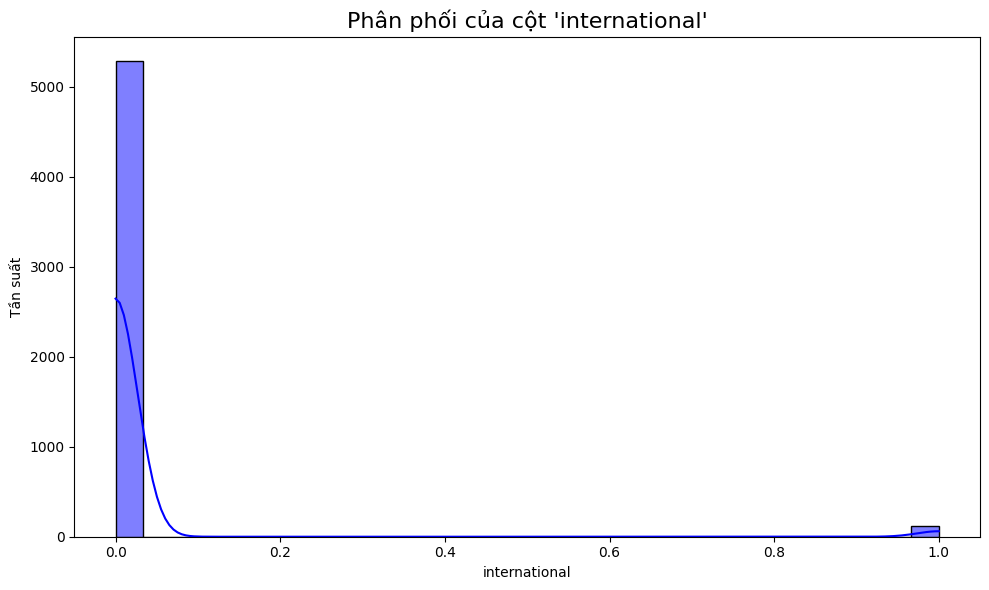

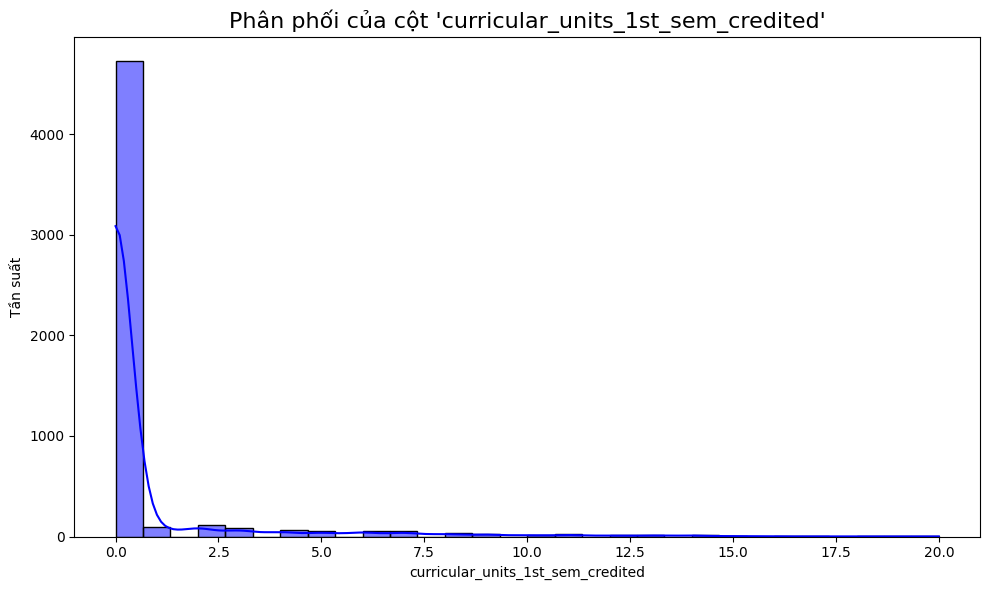

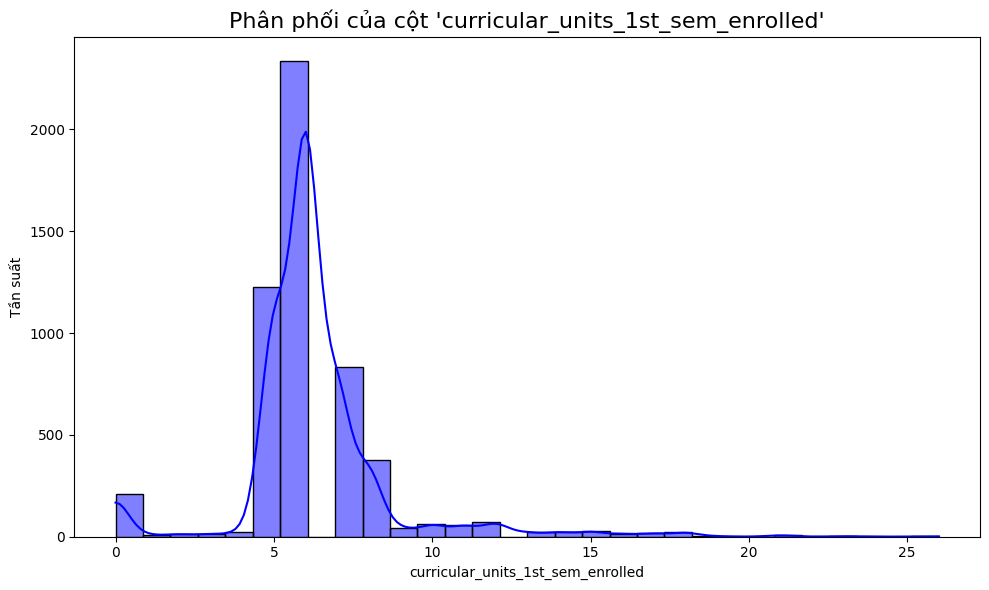

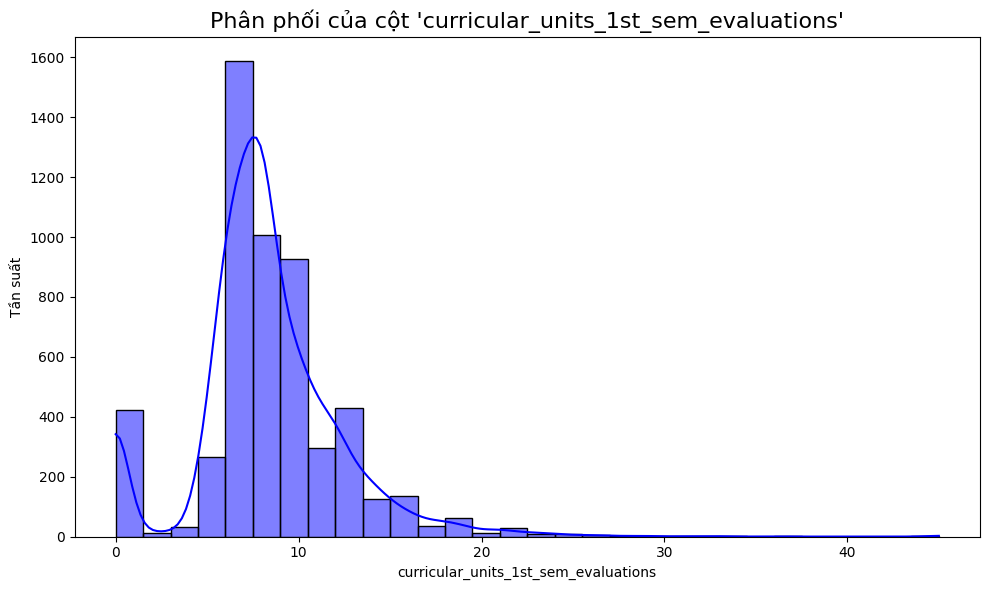

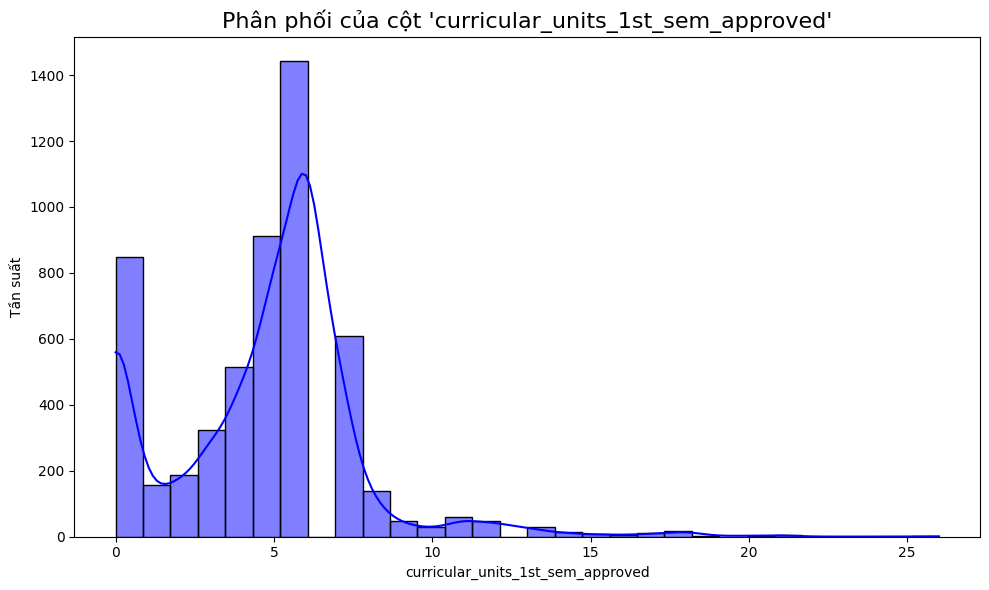

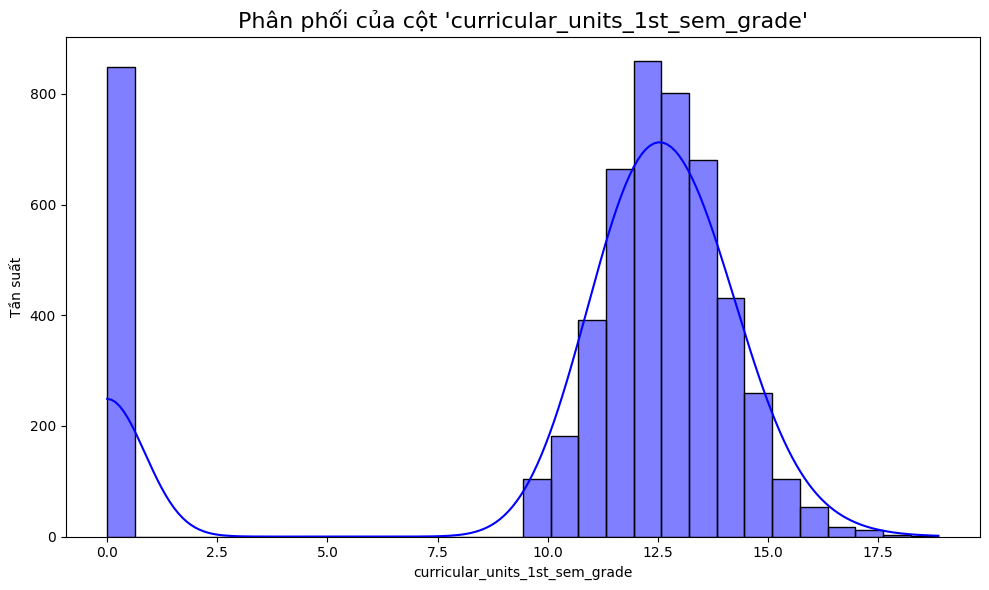

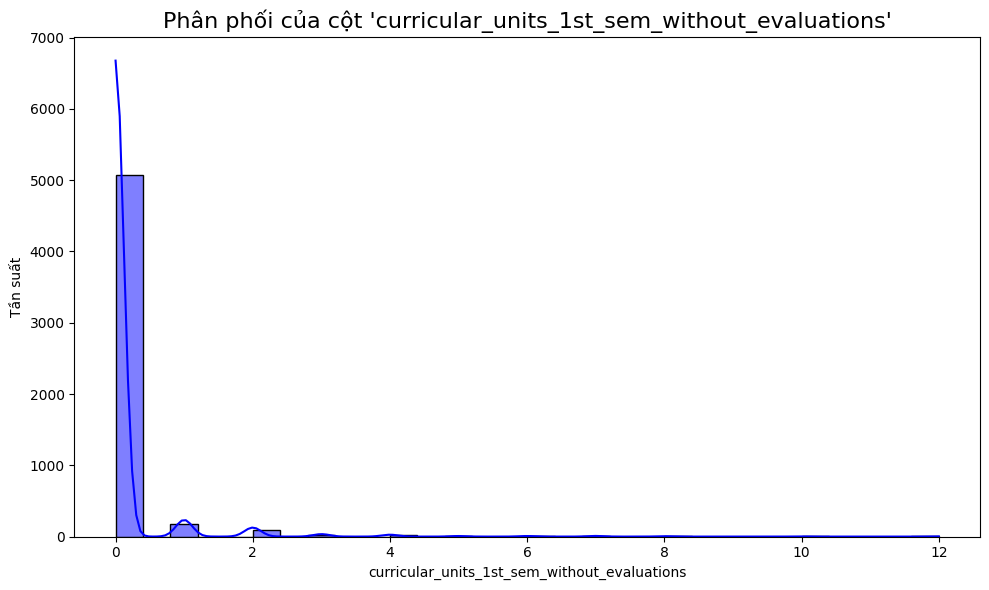

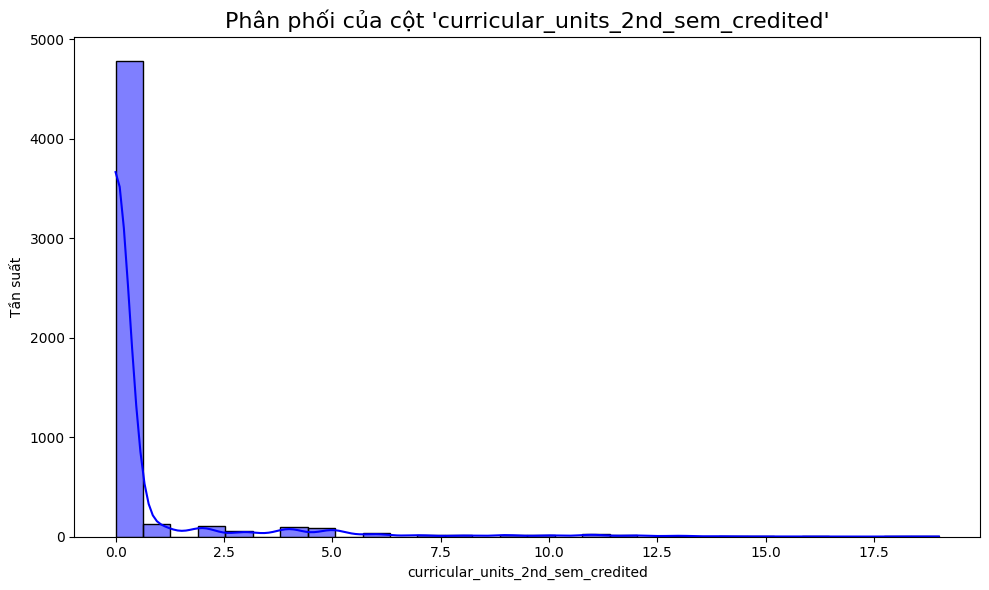

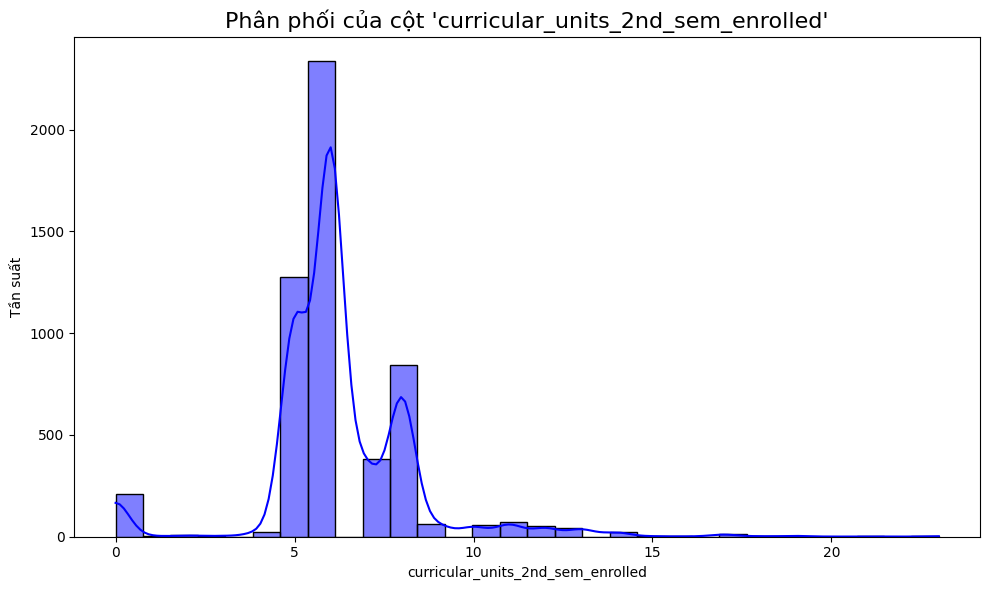

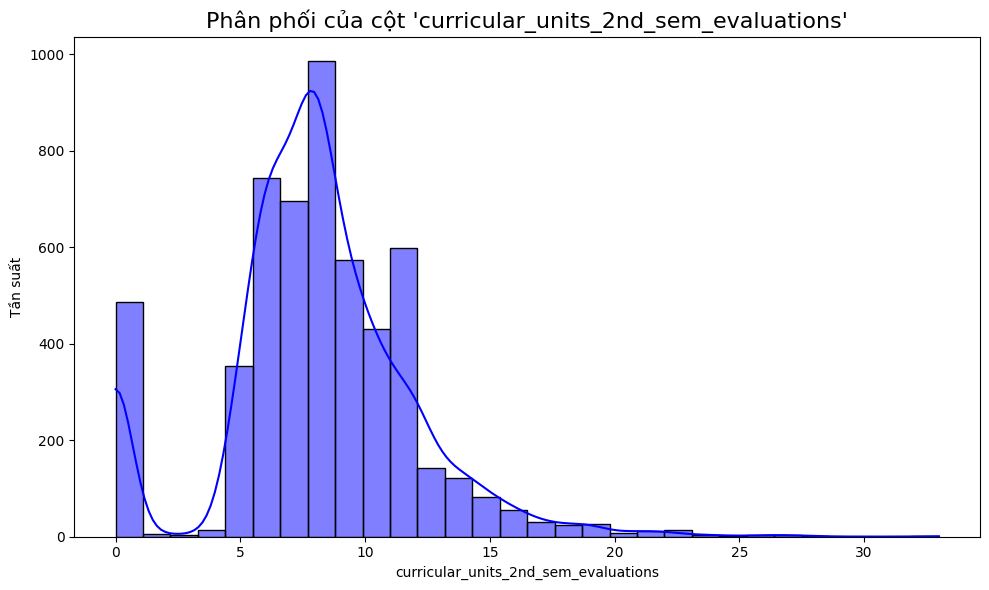

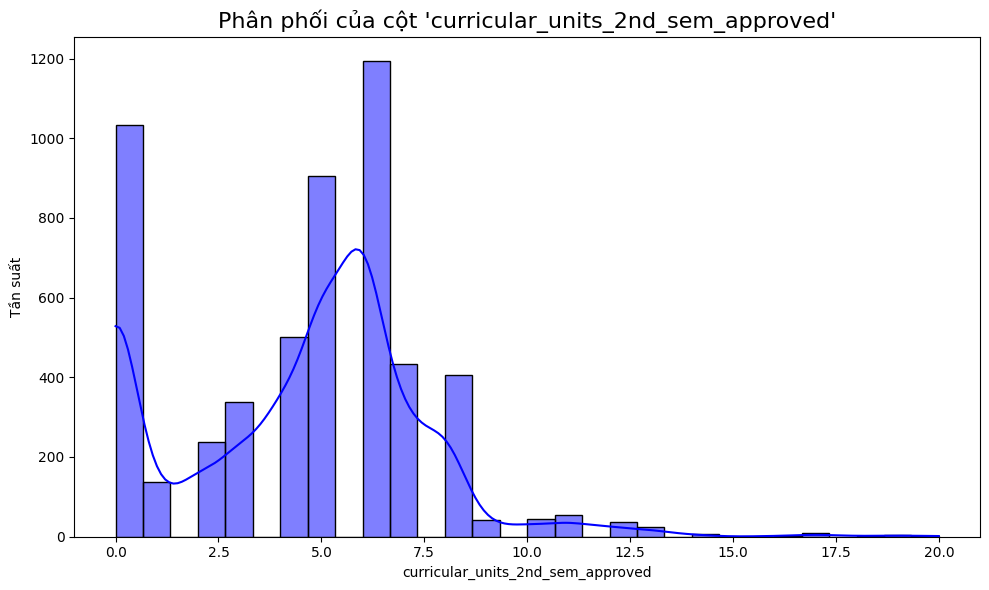

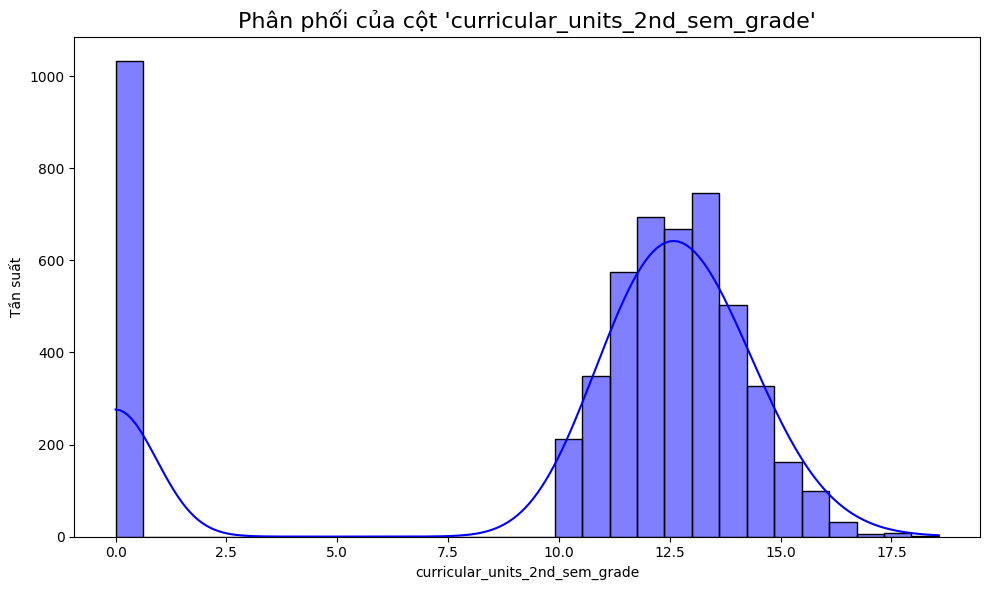

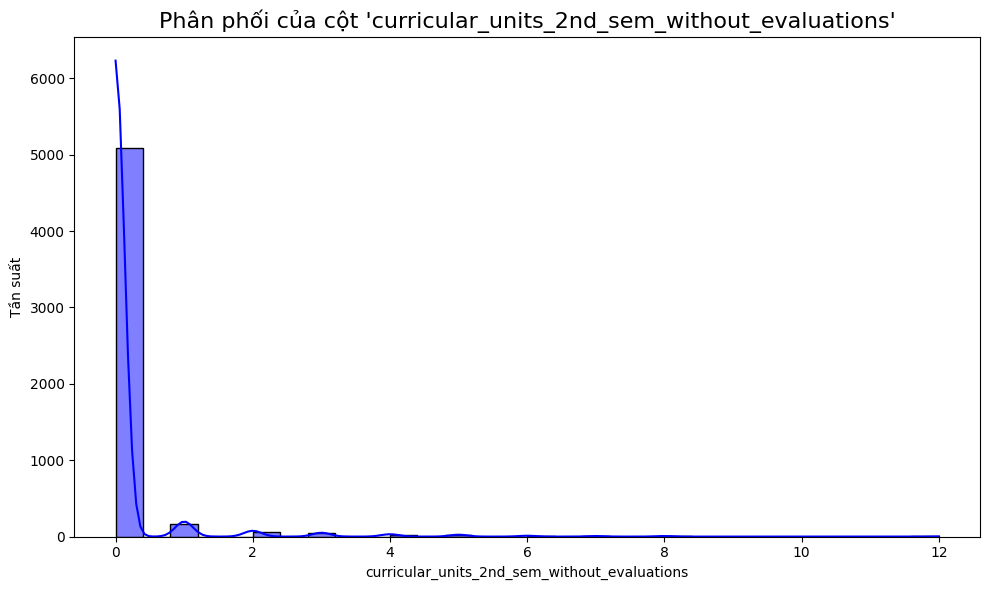

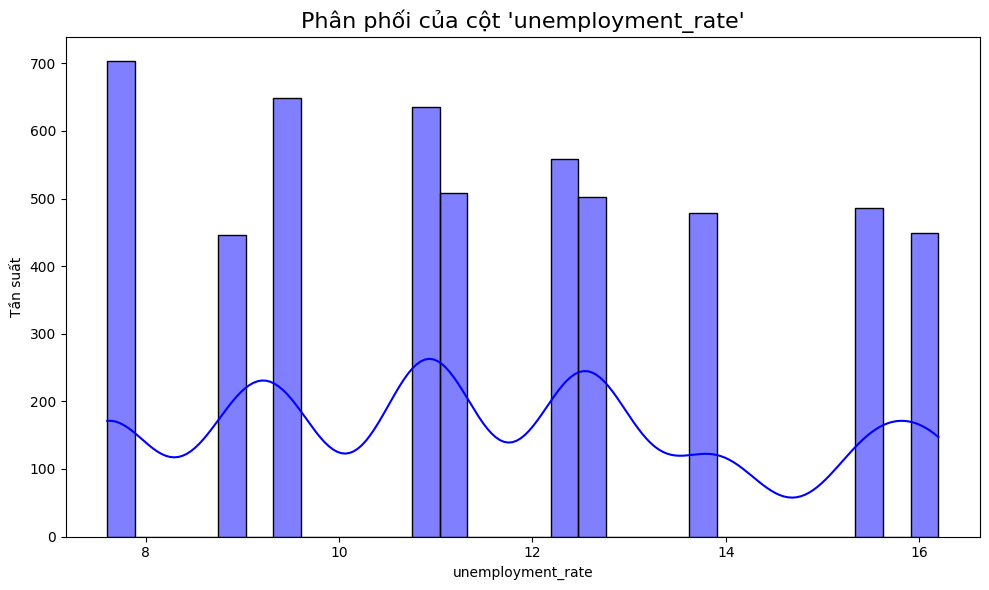

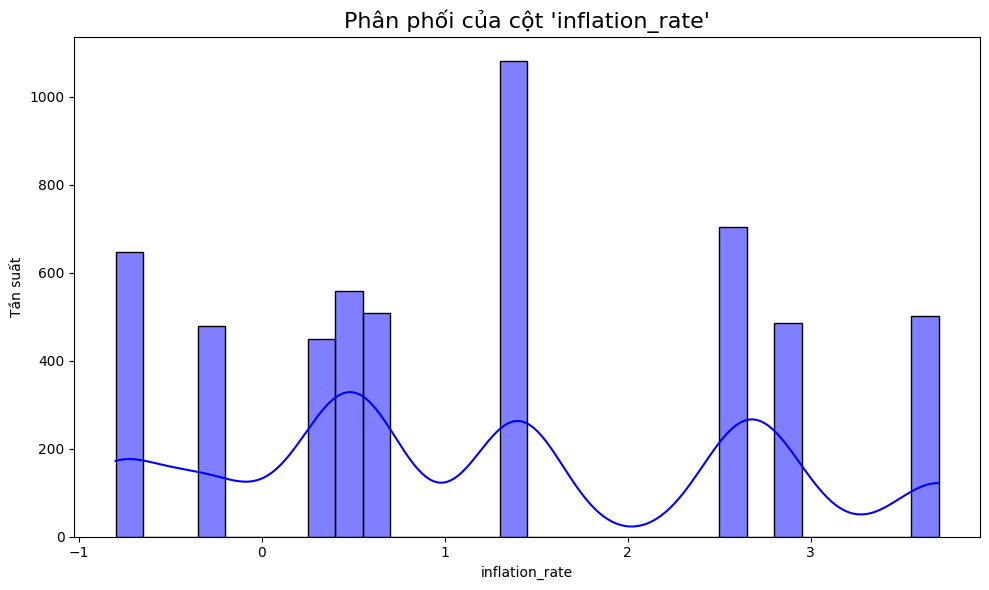

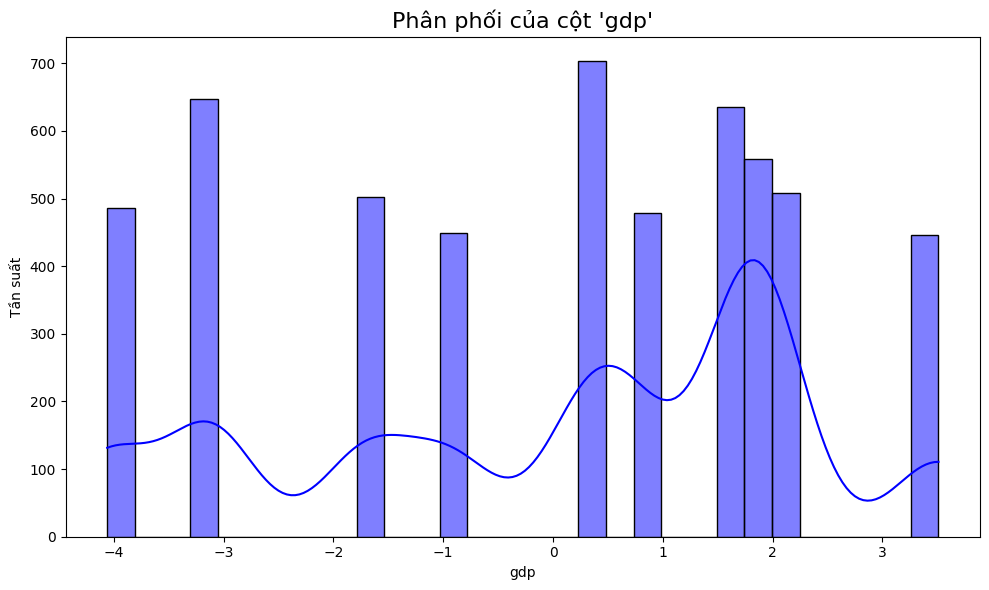

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19428\2813245344.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data[col], order=data[col].value_counts().index, palette="viridis")


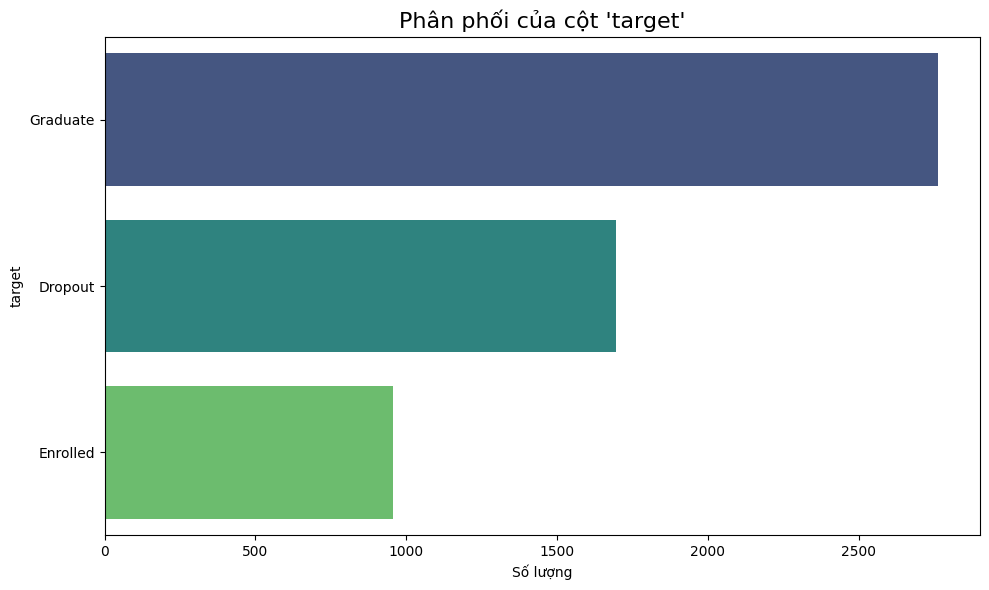

In [139]:
columns = data.columns

# Lặp qua từng cột và vẽ biểu đồ phân phối
for col in columns:
    plt.figure(figsize=(10, 6))
    if data[col].dtype == 'object':  # Nếu là cột phân loại (categorical)
        sns.countplot(y=data[col], order=data[col].value_counts().index, palette="viridis")
        plt.title(f"Phân phối của cột '{col}'", fontsize=16)
        plt.xlabel("Số lượng")
        plt.ylabel(col)
    else:  # Nếu là cột số (numerical)
        sns.histplot(data[col], kde=True, bins=30, color='blue')
        plt.title(f"Phân phối của cột '{col}'", fontsize=16)
        plt.xlabel(col)
        plt.ylabel("Tần suất")
    plt.tight_layout()
    plt.show()

target
Graduate    0.510434
Dropout     0.313019
Enrolled    0.176547
Name: proportion, dtype: float64


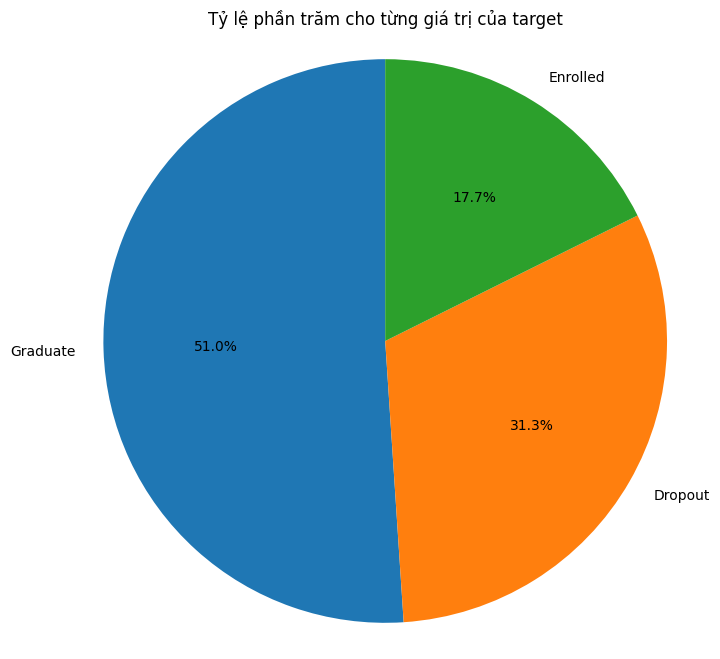

In [195]:
# Tính tỷ lệ phần trăm cho từng giá trị của target
target_distribution = data['target'].value_counts(normalize=True)
print(target_distribution)

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 8))
plt.pie(target_distribution, labels=target_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Tỷ lệ phần trăm cho từng giá trị của target')
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.show()

## MinMax Scaler

In [140]:
class MinMaxScaler:
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, data):
        self.min = data.min(dim=0)[0]
        self.max = data.max(dim=0)[0]

    def transform(self, data):
        return (data - self.min) / (self.max - self.min)

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

    def inverse_transform(self, scaled_data):
        return scaled_data * (self.max - self.min) + self.min         

## Build Dataset

In [141]:
class CSVCustomDataset(Dataset):
    def __init__(self, csv_file, target_column, transform=None, test = False):
        """
        Args:
            csv_file (str): Đường dẫn đến file CSV.
            target_column (str): Tên cột chứa nhãn (target).
            transform (callable, optional): Hàm để áp dụng các phép biến đổi dữ liệu.
        """
        # Đọc dữ liệu từ file CSV
        self.data = pd.read_csv(csv_file)
        len_data = len(data)
        test_len = int(len_data - 0.2*len_data)
        
        if not test:
            self.data = self.data.iloc[len_data - test_len:]
        else:
            self.data = self.data.iloc[:len_data - test_len]
        
        # Ghi lại cột nhãn và xử lý encoding
        self.target_column = target_column
        self.label_encoder = LabelEncoder()
        self.data[self.target_column] = self.label_encoder.fit_transform(self.data[self.target_column])
        
        # Tách features và target
        self.features = self.data.drop(columns=[self.target_column])
        self.targets = self.data[self.target_column]

        self.features = torch.tensor(self.features.values.astype(np.float32))

        # Chuẩn hóa dữ liệu số
        self.scaler = MinMaxScaler()
        self.features = self.scaler.fit_transform(self.features)
        
        # Biến đổi (nếu có)
        self.transform = transform

    def __len__(self):
        """Số lượng mẫu trong dataset"""
        return len(self.data)

    def __getitem__(self, idx):
        """Trả về một mẫu dữ liệu và nhãn tương ứng"""
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Lấy dữ liệu và nhãn
        features = self.features[idx]
        target = self.targets.iloc[idx].astype(np.int64)
        
        # Apply transform nếu có
        if self.transform:
            features = self.transform(features)
        
        return (features.clone(), torch.tensor(target))



## Build DataLoader

In [142]:
# Tạo DataLoader
def get_dataloader(csv_file, target_column="target",  batch_size=32, shuffle=True, num_workers=0):
    """
    Args:
        csv_file (str): Đường dẫn đến file CSV.
        target_column (str): Tên cột chứa nhãn (target).
        batch_size (int): Kích thước batch.
        shuffle (bool): Có xáo trộn dữ liệu hay không.
        num_workers (int): Số luồng để tải dữ liệu.
    Returns:
        DataLoader: Bộ DataLoader cho dataset.
    """
    train_dataset = CSVCustomDataset(csv_file, target_column=target_column, test=False)
    print(train_dataset.__len__())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, drop_last=True)

    test_dataset = CSVCustomDataset(csv_file, target_column=target_column, test=True)
    print(test_dataset.__len__())
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
    return train_dataloader, test_dataloader

## Test DataLoader

In [143]:
csv_file = "data.csv"
    
# Tên cột target
target_column = "target"

# Tạo DataLoader
train_loader, test_loader = get_dataloader(csv_file, target_column=target_column, batch_size=32)
    
# Kiểm tra train_loader
for batch_idx, (features, targets) in enumerate(train_loader):
    print(f"Train Batch {batch_idx + 1}")
    print("Features:", features.shape)  # Kích thước đặc trưng
    print("Targets:", targets.shape)    # Kích thước nhãn
    print(features[1])
    print(targets)
    break

# Kiểm tra test_loader
for batch_idx, (features, targets) in enumerate(test_loader):
    print(f"Test Batch {batch_idx + 1}")
    print("Features:", features.shape)  # Kích thước đặc trưng
    print("Targets:", targets.shape)    # Kích thước nhãn
    break

4332
1083
Train Batch 1
Features: torch.Size([32, 36])
Targets: torch.Size([32])
tensor([0.0000, 0.2857, 0.2222, 0.9781, 1.0000, 0.0000, 0.3895, 0.0000, 0.4186,
        0.4186, 0.0464, 0.0308, 0.2642, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0222, 0.0000, 0.0000, 0.2308, 0.1333, 0.2308, 0.7241, 0.0000,
        0.0000, 0.2609, 0.1818, 0.3000, 0.7538, 0.0000, 0.1512, 0.4889, 1.0000])
tensor([2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 2, 2, 2, 0, 1, 2, 1, 2, 0, 2,
        2, 2, 1, 0, 2, 0, 0, 0])
Test Batch 1
Features: torch.Size([32, 36])
Targets: torch.Size([32])


# Using Machine Learning Method

## Split Data

In [144]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target',axis=1), data['target'], test_size=0.2, random_state=101)

## Logistic Regression

In [145]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

c:\Users\ADMIN\miniconda3\envs\VLM\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [146]:
print("Accuracy: ", accuracy_score(y_test,predictions))
#print("F1 score: ", f1_score(y_test,predictions,pos_label='positive',average='micro'))
#print("Recall: ", recall_score(y_test,predictions,pos_label='positive',average='micro'))
#print("Precision: ", precision_score(y_test,predictions,pos_label='positive',average='micro'))
print("\n")
print(classification_report(y_test,predictions))
print("\n")
print(confusion_matrix(y_test,predictions))

Accuracy:  0.7700831024930748


              precision    recall  f1-score   support

     Dropout       0.82      0.78      0.79       347
    Enrolled       0.50      0.30      0.37       185
    Graduate       0.79      0.93      0.85       551

    accuracy                           0.77      1083
   macro avg       0.70      0.67      0.67      1083
weighted avg       0.75      0.77      0.75      1083



[[269  28  50]
 [ 46  55  84]
 [ 15  26 510]]


## K-Nearst Neighbor

In [147]:
from sklearn.neighbors import KNeighborsClassifier

In [148]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))



In [149]:
print(error_rate.index(min(error_rate[1:])))

13


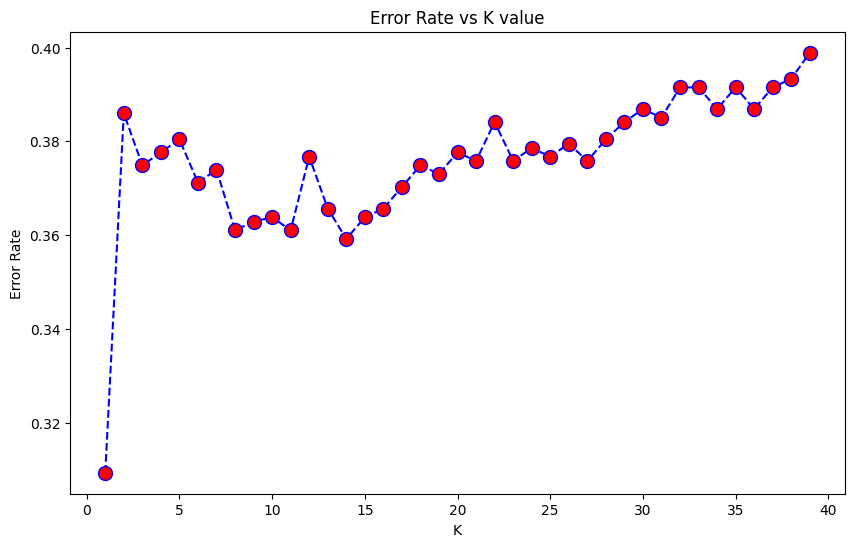

In [150]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue',linestyle='--',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs K value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.savefig("Error Rate vs K value.png") # save as png

In [151]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)

In [152]:
print("Accuracy: ", accuracy_score(y_test,predictions))
#print("F1 score: ", f1_score(y_test,predictions,pos_label='positive',average='micro'))
#print("Recall: ", recall_score(y_test,predictions,pos_label='positive',average='micro'))
#print("Precision: ", precision_score(y_test,predictions,pos_label='positive',average='micro'))
print("\n")
print(classification_report(y_test,predictions))
print("\n")
print(confusion_matrix(y_test,predictions))

Accuracy:  0.6343490304709142


              precision    recall  f1-score   support

     Dropout       0.63      0.54      0.58       347
    Enrolled       0.44      0.23      0.30       185
    Graduate       0.66      0.83      0.74       551

    accuracy                           0.63      1083
   macro avg       0.58      0.53      0.54      1083
weighted avg       0.61      0.63      0.61      1083



[[186  24 137]
 [ 46  43  96]
 [ 62  31 458]]


## Decision Tree

In [193]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

predictions = dtree.predict(X_test)

In [194]:
print("Accuracy: ", accuracy_score(y_test,predictions))
#print("F1 score: ", f1_score(y_test,predictions,pos_label='positive',average='micro'))
#print("Recall: ", recall_score(y_test,predictions,pos_label='positive',average='micro'))
#print("Precision: ", precision_score(y_test,predictions,pos_label='positive',average='micro'))
print("\n")
print(classification_report(y_test,predictions))
print("\n")
print(confusion_matrix(y_test,predictions))

Accuracy:  0.7728531855955678


              precision    recall  f1-score   support

     Dropout       0.77      0.76      0.77       347
    Enrolled       0.55      0.58      0.56       185
    Graduate       0.85      0.84      0.85       551

    accuracy                           0.77      1083
   macro avg       0.73      0.73      0.73      1083
weighted avg       0.78      0.77      0.77      1083



[[265  45  37]
 [ 34 107  44]
 [ 43  43 465]]


## Support Vector Machine

In [157]:
from sklearn.svm import SVC

model = SVC()

model.fit(X_train,y_train)

predictions = model.predict(X_test)

In [158]:
print("Accuracy: ", accuracy_score(y_test,predictions))
#print("F1 score: ", f1_score(y_test,predictions,pos_label='positive',average='micro'))
#print("Recall: ", recall_score(y_test,predictions,pos_label='positive',average='micro'))
#print("Precision: ", precision_score(y_test,predictions,pos_label='positive',average='micro'))
print("\n")
print(classification_report(y_test,predictions))
print("\n")
print(confusion_matrix(y_test,predictions))

Accuracy:  0.5087719298245614


              precision    recall  f1-score   support

     Dropout       0.00      0.00      0.00       347
    Enrolled       0.00      0.00      0.00       185
    Graduate       0.51      1.00      0.67       551

    accuracy                           0.51      1083
   macro avg       0.17      0.33      0.22      1083
weighted avg       0.26      0.51      0.34      1083



[[  0   0 347]
 [  0   0 185]
 [  0   0 551]]


c:\Users\ADMIN\miniconda3\envs\VLM\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\miniconda3\envs\VLM\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\miniconda3\envs\VLM\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Using Deep Learning Method

## Train Model

## Build MLP Model

In [159]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[128, 64], dropout=0):
        """
        Args:
            input_dim (int): Số lượng đặc trưng đầu vào (input features).
            num_classes (int): Số lớp (outputs).
            hidden_dims (list): Danh sách số lượng neurons ở mỗi layer ẩn.
            dropout (float): Tỷ lệ dropout để tránh overfitting.
        """
        super(MLPModel, self).__init__()
        
        layers = []
        in_dim = input_dim
        
        # Tạo các layer ẩn
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        
        # Tạo layer đầu ra
        layers.append(nn.Linear(in_dim, num_classes))
        
        self.mlp = nn.Sequential(*layers)
        self.softmax = nn.Softmax(-1)
    def forward(self, x):
        output = self.mlp(x)
        output = self.softmax(output)
        return output

model = MLPModel(36, 3)

dummy_input = torch.randn(32, 36)
output = model(dummy_input)
print(output.shape)

torch.Size([32, 3])


## Build MHA

In [188]:

class MultiheadAttentionModel(nn.Module):
    def __init__(self, feature_dim, embed_dim, num_heads, num_classes):
        """
        Initializes the Multihead Attention module.
        
        Args:
            feature_dim (int): Number of input features per time step.
            embed_dim (int): Embedding dimension for the attention mechanism.
            num_heads (int): Number of attention heads.
        """
        super(MultiheadAttentionModel, self).__init__()
        
        self.feature_dim = feature_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        # Linear projection layer if feature_dim != embed_dim
        if feature_dim != embed_dim:
            self.projection = nn.Linear(feature_dim, embed_dim)
        else:
            self.projection = None
        
        # Multihead attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.fc0 = nn.Linear(128, 64)
        self.act0 = nn.ReLU()
        self.fc1 = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(-1)

    def forward(self, x):
        """
        Forward pass of the Multihead Attention module.
        
        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, feature_dim).
        
        Returns:
            attn_output (Tensor): Output tensor after attention of shape (batch_size, seq_len, embed_dim).
            attn_weights (Tensor): Attention weights of shape (batch_size, num_heads, seq_len, seq_len).
        """
        # If needed, project the input to the embedding dimension
        if self.projection is not None:
            x = self.projection(x)  # Shape: (batch_size, seq_len, embed_dim)
        
        # Query, Key, and Value all come from the input
        attn_output, attn_weights = self.multihead_attn(x, x, x)  # batch_first=True keeps (batch_size, seq_len, embed_dim)
        
        

        output = self.fc0(attn_output)
        output = self.act0(output)

        output = self.fc1(output)
        output = self.softmax(output)

        return output
    
model = MultiheadAttentionModel(36, 128, 4, 3)

dummy_input = torch.randn(32, 36)
output = model(dummy_input)
print(output.shape)


torch.Size([32, 3])


## Build Trainer

In [161]:
class Trainer:
    def __init__(self, model, criterion, optimizer, num_epochs, device, model_name) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device
        self.best = 0
        self.model_name = model_name

    def train(self, train_loader, test_loader):
        for epoch in range(self.num_epochs):
            print("EPOCHS:", epoch+1)
            print("Train:")
            model.train()
            new_best = 0
            with tqdm.tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{self.num_epochs}', unit='batch') as pbar:
                for data in train_loader:
                    # clear gradient
                    self.model.zero_grad(set_to_none=True)
                    self.optimizer.zero_grad()
                    # get data

                    inputs = data[0].to(self.device)
                    targets = data[1]
                    targets = torch.nn.functional.one_hot(targets, num_classes=3)
                    targets = targets.to(self.device)
                    targets = targets.to(torch.float32)
                    
                    # compute output, loss and metrics
                    outputs = self.model(inputs)
                    _loss = self.criterion(outputs, targets)
                    
                    _loss.backward(retain_graph=True)
                    self.optimizer.step()
                    
                    acc = self.calculate_accuracy(outputs.to("cpu"), targets.to("cpu"))

                    pbar.set_postfix(loss=_loss.item(), acc = acc)
                    pbar.update(1)
            # new_best += acc
            print("Test")
            model.eval()
            with tqdm.tqdm(total=len(test_loader), desc=f'Epoch {epoch+1}/{self.num_epochs}', unit='batch') as pbar:
                list_predicts = []
                list_targets = []
                for data in test_loader:
                    # clear gradient
                    inputs = data[0].to(self.device)
                    targets = data[1]
                    targets = torch.nn.functional.one_hot(targets, num_classes=3)
                    targets = targets.to(self.device)
                    targets = targets.to(torch.float32)
                    
                    # compute output, loss and metrics
                    outputs = self.model(inputs)
                    _loss = self.criterion(outputs, targets)
                    
                    acc = self.calculate_accuracy(outputs.to("cpu"), targets.to("cpu"))

                    pbar.set_postfix(loss=_loss.item(), acc = acc)
                    pbar.update(1)

                    targets = torch.argmax(targets, dim=1)
                    outputs = torch.argmax(outputs, dim=1)

                    targets = targets.cpu().detach().tolist()
                    outputs = outputs.cpu().detach().tolist()

                    list_predicts += outputs
                    list_targets += targets
            
            list_targets = np.array(list_targets)
            list_predicts = np.array(list_predicts)

            acc =  accuracy_score(list_targets, list_predicts)
            print("Accuracy: ", acc)
            new_best = acc
            if new_best > self.best:
                self.best = new_best
                torch.save(self.model.state_dict(), f"./{self.model_name}_model.pth")
            print()

    def evaluate(self, model, test_loader):
        model.eval()
        list_predicts = []
        list_targets = []
        for data in test_loader:
            # clear gradient
            inputs = data[0].to(self.device)
            targets = data[1]
            targets = targets.cpu().detach().tolist()
            
            # compute output, loss and metrics
            outputs = self.model(inputs)
            outputs = torch.argmax(outputs, dim=1)

            outputs = outputs.cpu().detach().tolist()

            list_predicts += outputs
            list_targets += targets
        
        list_targets = np.array(list_targets)
        list_predicts = np.array(list_predicts)

        print("Accuracy: ", accuracy_score(list_targets, list_predicts))
        #print("F1 score: ", f1_score(list_targets,list_predicts,pos_label='positive',average='micro'))
        #print("Recall: ", recall_score(list_targets,list_predicts,pos_label='positive',average='micro'))
        #print("Precision: ", precision_score(list_targets,list_predicts,pos_label='positive',average='micro'))
        print("\n")
        print(classification_report(list_targets,list_predicts))
        print("\n")
        print(confusion_matrix(list_targets,list_predicts))

    def calculate_accuracy(self, list_predicts, targets):
        """
        Tính độ chính xác (accuracy) từ hai tensor one-hot.
        
        Args:
            list_predicts (torch.Tensor): Tensor dự đoán (one-hot), shape [batch_size, num_classes].
            targets (torch.Tensor): Tensor nhãn thật (one-hot), shape [batch_size, num_classes].
        
        Returns:
            float: Giá trị accuracy.
        """
        # Convert one-hot to class indices
        pred_indices = torch.argmax(list_predicts, dim=1)  # Shape: [batch_size]
        target_indices = torch.argmax(targets, dim=1)    # Shape: [batch_size]
        
        # Compare list_predicts with ground truth
        correct = torch.eq(pred_indices, target_indices)  # Shape: [batch_size], bool tensor
        
        # Compute accuracy
        accuracy = correct.sum().item() / correct.size(0)
        return accuracy

## Train Model

### Train MLP

In [162]:
model = MLPModel(36, 3, hidden_dims=[128, 64]).to(device)
print(model)

MLPModel(
  (mlp): Sequential(
    (0): Linear(in_features=36, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
  (softmax): Softmax(dim=-1)
)


In [163]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 50

In [164]:
trainer = Trainer(
                model=model,
                criterion=criterion,
                optimizer=optimizer,
                num_epochs=num_epochs,
                device = device,
                model_name="MLP"
)

In [165]:
trainer.train(train_loader, test_loader)

EPOCHS: 1
Train:


Epoch 1/50: 100%|██████████| 135/135 [00:01<00:00, 107.44batch/s, acc=0.688, loss=0.852]


Test


Epoch 1/50: 100%|██████████| 33/33 [00:00<00:00, 142.79batch/s, acc=0.844, loss=0.735]


Accuracy:  0.7376893939393939

EPOCHS: 2
Train:


Epoch 2/50: 100%|██████████| 135/135 [00:01<00:00, 117.75batch/s, acc=0.719, loss=0.827]


Test


Epoch 2/50: 100%|██████████| 33/33 [00:00<00:00, 140.65batch/s, acc=0.844, loss=0.726]


Accuracy:  0.7471590909090909

EPOCHS: 3
Train:


Epoch 3/50: 100%|██████████| 135/135 [00:01<00:00, 111.81batch/s, acc=0.781, loss=0.772]


Test


Epoch 3/50: 100%|██████████| 33/33 [00:00<00:00, 133.58batch/s, acc=0.844, loss=0.728]


Accuracy:  0.7537878787878788

EPOCHS: 4
Train:


Epoch 4/50: 100%|██████████| 135/135 [00:01<00:00, 120.38batch/s, acc=0.719, loss=0.811]


Test


Epoch 4/50: 100%|██████████| 33/33 [00:00<00:00, 141.81batch/s, acc=0.844, loss=0.729]


Accuracy:  0.7613636363636364

EPOCHS: 5
Train:


Epoch 5/50: 100%|██████████| 135/135 [00:01<00:00, 116.14batch/s, acc=0.719, loss=0.865]


Test


Epoch 5/50: 100%|██████████| 33/33 [00:00<00:00, 136.66batch/s, acc=0.781, loss=0.745]


Accuracy:  0.7670454545454546

EPOCHS: 6
Train:


Epoch 6/50: 100%|██████████| 135/135 [00:01<00:00, 108.32batch/s, acc=0.906, loss=0.659]


Test


Epoch 6/50: 100%|██████████| 33/33 [00:00<00:00, 122.65batch/s, acc=0.844, loss=0.716]


Accuracy:  0.7642045454545454

EPOCHS: 7
Train:


Epoch 7/50: 100%|██████████| 135/135 [00:01<00:00, 109.13batch/s, acc=0.781, loss=0.788]


Test


Epoch 7/50: 100%|██████████| 33/33 [00:00<00:00, 143.28batch/s, acc=0.781, loss=0.736]


Accuracy:  0.7660984848484849

EPOCHS: 8
Train:


Epoch 8/50: 100%|██████████| 135/135 [00:01<00:00, 115.44batch/s, acc=0.938, loss=0.63] 


Test


Epoch 8/50: 100%|██████████| 33/33 [00:00<00:00, 141.30batch/s, acc=0.844, loss=0.72] 


Accuracy:  0.7689393939393939

EPOCHS: 9
Train:


Epoch 9/50: 100%|██████████| 135/135 [00:01<00:00, 113.92batch/s, acc=0.75, loss=0.817] 


Test


Epoch 9/50: 100%|██████████| 33/33 [00:00<00:00, 140.68batch/s, acc=0.812, loss=0.722]


Accuracy:  0.78125

EPOCHS: 10
Train:


Epoch 10/50: 100%|██████████| 135/135 [00:01<00:00, 115.91batch/s, acc=0.781, loss=0.773]


Test


Epoch 10/50: 100%|██████████| 33/33 [00:00<00:00, 147.33batch/s, acc=0.844, loss=0.724]


Accuracy:  0.7774621212121212

EPOCHS: 11
Train:


Epoch 11/50: 100%|██████████| 135/135 [00:01<00:00, 107.13batch/s, acc=0.844, loss=0.708]


Test


Epoch 11/50: 100%|██████████| 33/33 [00:00<00:00, 142.17batch/s, acc=0.844, loss=0.711]


Accuracy:  0.7784090909090909

EPOCHS: 12
Train:


Epoch 12/50: 100%|██████████| 135/135 [00:01<00:00, 116.26batch/s, acc=0.781, loss=0.751]


Test


Epoch 12/50: 100%|██████████| 33/33 [00:00<00:00, 126.50batch/s, acc=0.844, loss=0.727]


Accuracy:  0.7803030303030303

EPOCHS: 13
Train:


Epoch 13/50: 100%|██████████| 135/135 [00:01<00:00, 113.61batch/s, acc=0.781, loss=0.784]


Test


Epoch 13/50: 100%|██████████| 33/33 [00:00<00:00, 140.84batch/s, acc=0.844, loss=0.74] 


Accuracy:  0.7698863636363636

EPOCHS: 14
Train:


Epoch 14/50: 100%|██████████| 135/135 [00:01<00:00, 113.85batch/s, acc=0.719, loss=0.761]


Test


Epoch 14/50: 100%|██████████| 33/33 [00:00<00:00, 143.90batch/s, acc=0.875, loss=0.702]


Accuracy:  0.7888257575757576

EPOCHS: 15
Train:


Epoch 15/50: 100%|██████████| 135/135 [00:01<00:00, 112.86batch/s, acc=0.719, loss=0.822]


Test


Epoch 15/50: 100%|██████████| 33/33 [00:00<00:00, 137.00batch/s, acc=0.844, loss=0.718]


Accuracy:  0.7869318181818182

EPOCHS: 16
Train:


Epoch 16/50: 100%|██████████| 135/135 [00:01<00:00, 112.99batch/s, acc=0.75, loss=0.771] 


Test


Epoch 16/50: 100%|██████████| 33/33 [00:00<00:00, 141.51batch/s, acc=0.875, loss=0.701]


Accuracy:  0.7916666666666666

EPOCHS: 17
Train:


Epoch 17/50: 100%|██████████| 135/135 [00:01<00:00, 111.19batch/s, acc=0.812, loss=0.766]


Test


Epoch 17/50: 100%|██████████| 33/33 [00:00<00:00, 147.64batch/s, acc=0.812, loss=0.726]


Accuracy:  0.7793560606060606

EPOCHS: 18
Train:


Epoch 18/50: 100%|██████████| 135/135 [00:01<00:00, 114.92batch/s, acc=0.75, loss=0.777] 


Test


Epoch 18/50: 100%|██████████| 33/33 [00:00<00:00, 136.68batch/s, acc=0.844, loss=0.709]


Accuracy:  0.7926136363636364

EPOCHS: 19
Train:


Epoch 19/50: 100%|██████████| 135/135 [00:01<00:00, 112.07batch/s, acc=0.625, loss=0.942]


Test


Epoch 19/50: 100%|██████████| 33/33 [00:00<00:00, 144.41batch/s, acc=0.812, loss=0.714]


Accuracy:  0.7878787878787878

EPOCHS: 20
Train:


Epoch 20/50: 100%|██████████| 135/135 [00:01<00:00, 115.91batch/s, acc=0.844, loss=0.694]


Test


Epoch 20/50: 100%|██████████| 33/33 [00:00<00:00, 137.19batch/s, acc=0.875, loss=0.708]


Accuracy:  0.7926136363636364

EPOCHS: 21
Train:


Epoch 21/50: 100%|██████████| 135/135 [00:01<00:00, 113.48batch/s, acc=0.812, loss=0.721]


Test


Epoch 21/50: 100%|██████████| 33/33 [00:00<00:00, 143.88batch/s, acc=0.812, loss=0.71] 


Accuracy:  0.7888257575757576

EPOCHS: 22
Train:


Epoch 22/50: 100%|██████████| 135/135 [00:01<00:00, 112.30batch/s, acc=0.812, loss=0.722]


Test


Epoch 22/50: 100%|██████████| 33/33 [00:00<00:00, 130.94batch/s, acc=0.844, loss=0.706]


Accuracy:  0.7840909090909091

EPOCHS: 23
Train:


Epoch 23/50: 100%|██████████| 135/135 [00:01<00:00, 113.57batch/s, acc=0.812, loss=0.743]


Test


Epoch 23/50: 100%|██████████| 33/33 [00:00<00:00, 146.70batch/s, acc=0.844, loss=0.695]


Accuracy:  0.7859848484848485

EPOCHS: 24
Train:


Epoch 24/50: 100%|██████████| 135/135 [00:01<00:00, 112.73batch/s, acc=0.875, loss=0.701]


Test


Epoch 24/50: 100%|██████████| 33/33 [00:00<00:00, 137.01batch/s, acc=0.875, loss=0.687]


Accuracy:  0.7945075757575758

EPOCHS: 25
Train:


Epoch 25/50: 100%|██████████| 135/135 [00:01<00:00, 115.73batch/s, acc=0.844, loss=0.691]


Test


Epoch 25/50: 100%|██████████| 33/33 [00:00<00:00, 149.78batch/s, acc=0.875, loss=0.685]


Accuracy:  0.790719696969697

EPOCHS: 26
Train:


Epoch 26/50: 100%|██████████| 135/135 [00:01<00:00, 113.69batch/s, acc=0.938, loss=0.645]


Test


Epoch 26/50: 100%|██████████| 33/33 [00:00<00:00, 145.85batch/s, acc=0.875, loss=0.69] 


Accuracy:  0.7954545454545454

EPOCHS: 27
Train:


Epoch 27/50: 100%|██████████| 135/135 [00:01<00:00, 109.54batch/s, acc=0.906, loss=0.657]


Test


Epoch 27/50: 100%|██████████| 33/33 [00:00<00:00, 139.19batch/s, acc=0.875, loss=0.695]


Accuracy:  0.7964015151515151

EPOCHS: 28
Train:


Epoch 28/50: 100%|██████████| 135/135 [00:01<00:00, 116.02batch/s, acc=0.875, loss=0.687]


Test


Epoch 28/50: 100%|██████████| 33/33 [00:00<00:00, 131.72batch/s, acc=0.844, loss=0.748]


Accuracy:  0.7575757575757576

EPOCHS: 29
Train:


Epoch 29/50: 100%|██████████| 135/135 [00:01<00:00, 114.59batch/s, acc=0.781, loss=0.759]


Test


Epoch 29/50: 100%|██████████| 33/33 [00:00<00:00, 139.97batch/s, acc=0.875, loss=0.689]


Accuracy:  0.7935606060606061

EPOCHS: 30
Train:


Epoch 30/50: 100%|██████████| 135/135 [00:01<00:00, 109.80batch/s, acc=0.781, loss=0.765]


Test


Epoch 30/50: 100%|██████████| 33/33 [00:00<00:00, 128.53batch/s, acc=0.875, loss=0.693]


Accuracy:  0.7973484848484849

EPOCHS: 31
Train:


Epoch 31/50: 100%|██████████| 135/135 [00:01<00:00, 114.86batch/s, acc=0.844, loss=0.686]


Test


Epoch 31/50: 100%|██████████| 33/33 [00:00<00:00, 149.25batch/s, acc=0.875, loss=0.688]


Accuracy:  0.7964015151515151

EPOCHS: 32
Train:


Epoch 32/50: 100%|██████████| 135/135 [00:01<00:00, 114.95batch/s, acc=0.875, loss=0.688]


Test


Epoch 32/50: 100%|██████████| 33/33 [00:00<00:00, 127.75batch/s, acc=0.844, loss=0.711]


Accuracy:  0.7869318181818182

EPOCHS: 33
Train:


Epoch 33/50: 100%|██████████| 135/135 [00:01<00:00, 119.19batch/s, acc=0.75, loss=0.786] 


Test


Epoch 33/50: 100%|██████████| 33/33 [00:00<00:00, 151.79batch/s, acc=0.875, loss=0.693]


Accuracy:  0.7992424242424242

EPOCHS: 34
Train:


Epoch 34/50: 100%|██████████| 135/135 [00:01<00:00, 115.07batch/s, acc=0.812, loss=0.744]


Test


Epoch 34/50: 100%|██████████| 33/33 [00:00<00:00, 142.11batch/s, acc=0.875, loss=0.687]


Accuracy:  0.8039772727272727

EPOCHS: 35
Train:


Epoch 35/50: 100%|██████████| 135/135 [00:01<00:00, 116.84batch/s, acc=0.875, loss=0.696]


Test


Epoch 35/50: 100%|██████████| 33/33 [00:00<00:00, 146.04batch/s, acc=0.875, loss=0.687]


Accuracy:  0.7954545454545454

EPOCHS: 36
Train:


Epoch 36/50: 100%|██████████| 135/135 [00:01<00:00, 112.49batch/s, acc=0.781, loss=0.766]


Test


Epoch 36/50: 100%|██████████| 33/33 [00:00<00:00, 152.80batch/s, acc=0.812, loss=0.718]


Accuracy:  0.7926136363636364

EPOCHS: 37
Train:


Epoch 37/50: 100%|██████████| 135/135 [00:01<00:00, 116.07batch/s, acc=0.906, loss=0.654]


Test


Epoch 37/50: 100%|██████████| 33/33 [00:00<00:00, 135.76batch/s, acc=0.875, loss=0.682]


Accuracy:  0.8011363636363636

EPOCHS: 38
Train:


Epoch 38/50: 100%|██████████| 135/135 [00:01<00:00, 106.90batch/s, acc=0.781, loss=0.763]


Test


Epoch 38/50: 100%|██████████| 33/33 [00:00<00:00, 123.99batch/s, acc=0.844, loss=0.714]


Accuracy:  0.7888257575757576

EPOCHS: 39
Train:


Epoch 39/50: 100%|██████████| 135/135 [00:01<00:00, 105.98batch/s, acc=0.781, loss=0.797]


Test


Epoch 39/50: 100%|██████████| 33/33 [00:00<00:00, 131.96batch/s, acc=0.844, loss=0.698]


Accuracy:  0.8020833333333334

EPOCHS: 40
Train:


Epoch 40/50: 100%|██████████| 135/135 [00:01<00:00, 109.58batch/s, acc=0.875, loss=0.691]


Test


Epoch 40/50: 100%|██████████| 33/33 [00:00<00:00, 133.02batch/s, acc=0.875, loss=0.685]


Accuracy:  0.8068181818181818

EPOCHS: 41
Train:


Epoch 41/50: 100%|██████████| 135/135 [00:01<00:00, 111.81batch/s, acc=0.844, loss=0.694]


Test


Epoch 41/50: 100%|██████████| 33/33 [00:00<00:00, 155.11batch/s, acc=0.875, loss=0.696]


Accuracy:  0.7945075757575758

EPOCHS: 42
Train:


Epoch 42/50: 100%|██████████| 135/135 [00:01<00:00, 124.54batch/s, acc=0.844, loss=0.721]


Test


Epoch 42/50: 100%|██████████| 33/33 [00:00<00:00, 149.53batch/s, acc=0.875, loss=0.682]


Accuracy:  0.8049242424242424

EPOCHS: 43
Train:


Epoch 43/50: 100%|██████████| 135/135 [00:01<00:00, 120.03batch/s, acc=0.938, loss=0.642]


Test


Epoch 43/50: 100%|██████████| 33/33 [00:00<00:00, 153.57batch/s, acc=0.875, loss=0.692]


Accuracy:  0.8001893939393939

EPOCHS: 44
Train:


Epoch 44/50: 100%|██████████| 135/135 [00:01<00:00, 124.51batch/s, acc=0.844, loss=0.721]


Test


Epoch 44/50: 100%|██████████| 33/33 [00:00<00:00, 156.12batch/s, acc=0.844, loss=0.706]


Accuracy:  0.8068181818181818

EPOCHS: 45
Train:


Epoch 45/50: 100%|██████████| 135/135 [00:01<00:00, 124.88batch/s, acc=0.781, loss=0.762]


Test


Epoch 45/50: 100%|██████████| 33/33 [00:00<00:00, 144.41batch/s, acc=0.875, loss=0.693]


Accuracy:  0.8068181818181818

EPOCHS: 46
Train:


Epoch 46/50: 100%|██████████| 135/135 [00:01<00:00, 126.81batch/s, acc=0.781, loss=0.764]


Test


Epoch 46/50: 100%|██████████| 33/33 [00:00<00:00, 153.23batch/s, acc=0.875, loss=0.684]


Accuracy:  0.8087121212121212

EPOCHS: 47
Train:


Epoch 47/50: 100%|██████████| 135/135 [00:01<00:00, 118.78batch/s, acc=0.875, loss=0.682]


Test


Epoch 47/50: 100%|██████████| 33/33 [00:00<00:00, 154.80batch/s, acc=0.875, loss=0.683]


Accuracy:  0.803030303030303

EPOCHS: 48
Train:


Epoch 48/50: 100%|██████████| 135/135 [00:01<00:00, 122.56batch/s, acc=0.906, loss=0.637]


Test


Epoch 48/50: 100%|██████████| 33/33 [00:00<00:00, 149.86batch/s, acc=0.875, loss=0.684]


Accuracy:  0.8134469696969697

EPOCHS: 49
Train:


Epoch 49/50: 100%|██████████| 135/135 [00:01<00:00, 119.31batch/s, acc=0.781, loss=0.748]


Test


Epoch 49/50: 100%|██████████| 33/33 [00:00<00:00, 152.06batch/s, acc=0.875, loss=0.69] 


Accuracy:  0.8106060606060606

EPOCHS: 50
Train:


Epoch 50/50: 100%|██████████| 135/135 [00:01<00:00, 123.77batch/s, acc=0.75, loss=0.779] 


Test


Epoch 50/50: 100%|██████████| 33/33 [00:00<00:00, 143.04batch/s, acc=0.875, loss=0.695]

Accuracy:  0.8115530303030303



In [166]:
model.load_state_dict(torch.load(f"./{trainer.model_name}_model.pth", weights_only=True))

trainer.evaluate(model, test_loader)


Accuracy:  0.8134469696969697


              precision    recall  f1-score   support

           0       0.84      0.80      0.82       304
           1       0.62      0.48      0.54       178
           2       0.84      0.93      0.88       574

    accuracy                           0.81      1056
   macro avg       0.77      0.73      0.75      1056
weighted avg       0.80      0.81      0.81      1056



[[243  20  41]
 [ 35  85  58]
 [ 11  32 531]]


### Train MHA

In [189]:
model = MultiheadAttentionModel(36, 128, 4, 3).to(device)
print(model)

MultiheadAttentionModel(
  (projection): Linear(in_features=36, out_features=128, bias=True)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc0): Linear(in_features=128, out_features=64, bias=True)
  (act0): ReLU()
  (fc1): Linear(in_features=64, out_features=3, bias=True)
  (softmax): Softmax(dim=-1)
)


In [190]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 50

In [191]:
trainer = Trainer(
                model=model,
                criterion=criterion,
                optimizer=optimizer,
                num_epochs=num_epochs,
                device = device,
                model_name="MHA"
)

In [192]:
trainer.train(train_loader, test_loader)

model.load_state_dict(torch.load(f"./{trainer.model_name}_model.pth", weights_only=True))

trainer.evaluate(model, test_loader)



EPOCHS: 1
Train:


Epoch 1/50: 100%|██████████| 135/135 [00:01<00:00, 79.26batch/s, acc=0.719, loss=0.831]


Test


Epoch 1/50: 100%|██████████| 33/33 [00:00<00:00, 125.10batch/s, acc=0.812, loss=0.732]


Accuracy:  0.6827651515151515

EPOCHS: 2
Train:


Epoch 2/50: 100%|██████████| 135/135 [00:01<00:00, 83.11batch/s, acc=0.656, loss=0.877]


Test


Epoch 2/50: 100%|██████████| 33/33 [00:00<00:00, 124.63batch/s, acc=0.781, loss=0.75] 


Accuracy:  0.7225378787878788

EPOCHS: 3
Train:


Epoch 3/50: 100%|██████████| 135/135 [00:01<00:00, 86.34batch/s, acc=0.688, loss=0.883]


Test


Epoch 3/50: 100%|██████████| 33/33 [00:00<00:00, 133.66batch/s, acc=0.844, loss=0.749]


Accuracy:  0.7367424242424242

EPOCHS: 4
Train:


Epoch 4/50: 100%|██████████| 135/135 [00:01<00:00, 84.51batch/s, acc=0.719, loss=0.838]


Test


Epoch 4/50: 100%|██████████| 33/33 [00:00<00:00, 131.89batch/s, acc=0.844, loss=0.721]


Accuracy:  0.71875

EPOCHS: 5
Train:


Epoch 5/50: 100%|██████████| 135/135 [00:01<00:00, 85.72batch/s, acc=0.812, loss=0.701]


Test


Epoch 5/50: 100%|██████████| 33/33 [00:00<00:00, 125.73batch/s, acc=0.812, loss=0.741]


Accuracy:  0.7433712121212122

EPOCHS: 6
Train:


Epoch 6/50: 100%|██████████| 135/135 [00:01<00:00, 85.53batch/s, acc=0.688, loss=0.845]


Test


Epoch 6/50: 100%|██████████| 33/33 [00:00<00:00, 132.57batch/s, acc=0.844, loss=0.725]


Accuracy:  0.7310606060606061

EPOCHS: 7
Train:


Epoch 7/50: 100%|██████████| 135/135 [00:01<00:00, 85.24batch/s, acc=0.812, loss=0.741]


Test


Epoch 7/50: 100%|██████████| 33/33 [00:00<00:00, 121.52batch/s, acc=0.781, loss=0.764]


Accuracy:  0.7443181818181818

EPOCHS: 8
Train:


Epoch 8/50: 100%|██████████| 135/135 [00:01<00:00, 82.26batch/s, acc=0.75, loss=0.804] 


Test


Epoch 8/50: 100%|██████████| 33/33 [00:00<00:00, 123.90batch/s, acc=0.844, loss=0.724]


Accuracy:  0.7424242424242424

EPOCHS: 9
Train:


Epoch 9/50: 100%|██████████| 135/135 [00:01<00:00, 80.65batch/s, acc=0.688, loss=0.837]


Test


Epoch 9/50: 100%|██████████| 33/33 [00:00<00:00, 121.52batch/s, acc=0.812, loss=0.732]


Accuracy:  0.7424242424242424

EPOCHS: 10
Train:


Epoch 10/50: 100%|██████████| 135/135 [00:01<00:00, 81.64batch/s, acc=0.812, loss=0.727]


Test


Epoch 10/50: 100%|██████████| 33/33 [00:00<00:00, 111.17batch/s, acc=0.844, loss=0.717]


Accuracy:  0.7433712121212122

EPOCHS: 11
Train:


Epoch 11/50: 100%|██████████| 135/135 [00:01<00:00, 82.29batch/s, acc=0.688, loss=0.855]


Test


Epoch 11/50: 100%|██████████| 33/33 [00:00<00:00, 134.03batch/s, acc=0.812, loss=0.728]


Accuracy:  0.7528409090909091

EPOCHS: 12
Train:


Epoch 12/50: 100%|██████████| 135/135 [00:01<00:00, 83.66batch/s, acc=0.812, loss=0.72] 


Test


Epoch 12/50: 100%|██████████| 33/33 [00:00<00:00, 112.89batch/s, acc=0.812, loss=0.735]


Accuracy:  0.7462121212121212

EPOCHS: 13
Train:


Epoch 13/50: 100%|██████████| 135/135 [00:01<00:00, 83.95batch/s, acc=0.875, loss=0.666]


Test


Epoch 13/50: 100%|██████████| 33/33 [00:00<00:00, 123.94batch/s, acc=0.844, loss=0.724]


Accuracy:  0.7537878787878788

EPOCHS: 14
Train:


Epoch 14/50: 100%|██████████| 135/135 [00:01<00:00, 82.01batch/s, acc=0.75, loss=0.772] 


Test


Epoch 14/50: 100%|██████████| 33/33 [00:00<00:00, 127.00batch/s, acc=0.844, loss=0.712]


Accuracy:  0.7301136363636364

EPOCHS: 15
Train:


Epoch 15/50: 100%|██████████| 135/135 [00:01<00:00, 82.37batch/s, acc=0.719, loss=0.848]


Test


Epoch 15/50: 100%|██████████| 33/33 [00:00<00:00, 128.76batch/s, acc=0.812, loss=0.712]


Accuracy:  0.75

EPOCHS: 16
Train:


Epoch 16/50: 100%|██████████| 135/135 [00:01<00:00, 83.07batch/s, acc=0.594, loss=0.952]


Test


Epoch 16/50: 100%|██████████| 33/33 [00:00<00:00, 130.68batch/s, acc=0.844, loss=0.716]


Accuracy:  0.7755681818181818

EPOCHS: 17
Train:


Epoch 17/50: 100%|██████████| 135/135 [00:01<00:00, 84.95batch/s, acc=0.875, loss=0.665]


Test


Epoch 17/50: 100%|██████████| 33/33 [00:00<00:00, 140.00batch/s, acc=0.812, loss=0.723]


Accuracy:  0.7651515151515151

EPOCHS: 18
Train:


Epoch 18/50: 100%|██████████| 135/135 [00:01<00:00, 84.50batch/s, acc=0.688, loss=0.837]


Test


Epoch 18/50: 100%|██████████| 33/33 [00:00<00:00, 143.06batch/s, acc=0.812, loss=0.736]


Accuracy:  0.7471590909090909

EPOCHS: 19
Train:


Epoch 19/50: 100%|██████████| 135/135 [00:01<00:00, 85.42batch/s, acc=0.844, loss=0.686]


Test


Epoch 19/50: 100%|██████████| 33/33 [00:00<00:00, 110.80batch/s, acc=0.844, loss=0.712]


Accuracy:  0.7604166666666666

EPOCHS: 20
Train:


Epoch 20/50: 100%|██████████| 135/135 [00:01<00:00, 84.43batch/s, acc=0.812, loss=0.738]


Test


Epoch 20/50: 100%|██████████| 33/33 [00:00<00:00, 128.98batch/s, acc=0.844, loss=0.715]


Accuracy:  0.7632575757575758

EPOCHS: 21
Train:


Epoch 21/50: 100%|██████████| 135/135 [00:01<00:00, 81.24batch/s, acc=0.625, loss=0.922]


Test


Epoch 21/50: 100%|██████████| 33/33 [00:00<00:00, 128.93batch/s, acc=0.844, loss=0.726]


Accuracy:  0.7452651515151515

EPOCHS: 22
Train:


Epoch 22/50: 100%|██████████| 135/135 [00:01<00:00, 86.90batch/s, acc=0.875, loss=0.666]


Test


Epoch 22/50: 100%|██████████| 33/33 [00:00<00:00, 134.40batch/s, acc=0.844, loss=0.718]


Accuracy:  0.7537878787878788

EPOCHS: 23
Train:


Epoch 23/50: 100%|██████████| 135/135 [00:01<00:00, 83.41batch/s, acc=0.844, loss=0.706]


Test


Epoch 23/50: 100%|██████████| 33/33 [00:00<00:00, 133.14batch/s, acc=0.844, loss=0.715]


Accuracy:  0.7679924242424242

EPOCHS: 24
Train:


Epoch 24/50: 100%|██████████| 135/135 [00:01<00:00, 84.64batch/s, acc=0.812, loss=0.703]


Test


Epoch 24/50: 100%|██████████| 33/33 [00:00<00:00, 134.23batch/s, acc=0.688, loss=0.803]


Accuracy:  0.75

EPOCHS: 25
Train:


Epoch 25/50: 100%|██████████| 135/135 [00:01<00:00, 83.11batch/s, acc=0.75, loss=0.802] 


Test


Epoch 25/50: 100%|██████████| 33/33 [00:00<00:00, 135.84batch/s, acc=0.844, loss=0.717]


Accuracy:  0.7575757575757576

EPOCHS: 26
Train:


Epoch 26/50: 100%|██████████| 135/135 [00:01<00:00, 86.49batch/s, acc=0.844, loss=0.714]


Test


Epoch 26/50: 100%|██████████| 33/33 [00:00<00:00, 116.03batch/s, acc=0.812, loss=0.719]


Accuracy:  0.7528409090909091

EPOCHS: 27
Train:


Epoch 27/50: 100%|██████████| 135/135 [00:01<00:00, 86.97batch/s, acc=0.781, loss=0.731]


Test


Epoch 27/50: 100%|██████████| 33/33 [00:00<00:00, 128.86batch/s, acc=0.812, loss=0.707]


Accuracy:  0.771780303030303

EPOCHS: 28
Train:


Epoch 28/50: 100%|██████████| 135/135 [00:01<00:00, 86.03batch/s, acc=0.781, loss=0.789]


Test


Epoch 28/50: 100%|██████████| 33/33 [00:00<00:00, 127.93batch/s, acc=0.844, loss=0.716]


Accuracy:  0.7623106060606061

EPOCHS: 29
Train:


Epoch 29/50: 100%|██████████| 135/135 [00:01<00:00, 82.03batch/s, acc=0.656, loss=0.876]


Test


Epoch 29/50: 100%|██████████| 33/33 [00:00<00:00, 125.12batch/s, acc=0.812, loss=0.732]


Accuracy:  0.7424242424242424

EPOCHS: 30
Train:


Epoch 30/50: 100%|██████████| 135/135 [00:01<00:00, 85.54batch/s, acc=0.562, loss=1]    


Test


Epoch 30/50: 100%|██████████| 33/33 [00:00<00:00, 138.72batch/s, acc=0.812, loss=0.738]


Accuracy:  0.759469696969697

EPOCHS: 31
Train:


Epoch 31/50: 100%|██████████| 135/135 [00:01<00:00, 88.59batch/s, acc=0.812, loss=0.708]


Test


Epoch 31/50: 100%|██████████| 33/33 [00:00<00:00, 114.82batch/s, acc=0.812, loss=0.733]


Accuracy:  0.740530303030303

EPOCHS: 32
Train:


Epoch 32/50: 100%|██████████| 135/135 [00:01<00:00, 80.54batch/s, acc=0.844, loss=0.71] 


Test


Epoch 32/50: 100%|██████████| 33/33 [00:00<00:00, 141.28batch/s, acc=0.844, loss=0.712]


Accuracy:  0.7727272727272727

EPOCHS: 33
Train:


Epoch 33/50: 100%|██████████| 135/135 [00:01<00:00, 80.04batch/s, acc=0.812, loss=0.717]


Test


Epoch 33/50: 100%|██████████| 33/33 [00:00<00:00, 125.11batch/s, acc=0.781, loss=0.721]


Accuracy:  0.7556818181818182

EPOCHS: 34
Train:


Epoch 34/50: 100%|██████████| 135/135 [00:01<00:00, 83.15batch/s, acc=0.812, loss=0.762]


Test


Epoch 34/50: 100%|██████████| 33/33 [00:00<00:00, 120.93batch/s, acc=0.812, loss=0.711]


Accuracy:  0.7736742424242424

EPOCHS: 35
Train:


Epoch 35/50: 100%|██████████| 135/135 [00:01<00:00, 84.42batch/s, acc=0.656, loss=0.891]


Test


Epoch 35/50: 100%|██████████| 33/33 [00:00<00:00, 123.79batch/s, acc=0.844, loss=0.72] 


Accuracy:  0.7708333333333334

EPOCHS: 36
Train:


Epoch 36/50: 100%|██████████| 135/135 [00:01<00:00, 84.71batch/s, acc=0.719, loss=0.824]


Test


Epoch 36/50: 100%|██████████| 33/33 [00:00<00:00, 122.66batch/s, acc=0.844, loss=0.709]


Accuracy:  0.7689393939393939

EPOCHS: 37
Train:


Epoch 37/50: 100%|██████████| 135/135 [00:01<00:00, 84.34batch/s, acc=0.719, loss=0.834]


Test


Epoch 37/50: 100%|██████████| 33/33 [00:00<00:00, 137.28batch/s, acc=0.844, loss=0.717]


Accuracy:  0.771780303030303

EPOCHS: 38
Train:


Epoch 38/50: 100%|██████████| 135/135 [00:01<00:00, 86.23batch/s, acc=0.812, loss=0.728]


Test


Epoch 38/50: 100%|██████████| 33/33 [00:00<00:00, 115.86batch/s, acc=0.812, loss=0.718]


Accuracy:  0.7727272727272727

EPOCHS: 39
Train:


Epoch 39/50: 100%|██████████| 135/135 [00:01<00:00, 87.52batch/s, acc=0.812, loss=0.738]


Test


Epoch 39/50: 100%|██████████| 33/33 [00:00<00:00, 129.20batch/s, acc=0.844, loss=0.715]


Accuracy:  0.7651515151515151

EPOCHS: 40
Train:


Epoch 40/50: 100%|██████████| 135/135 [00:01<00:00, 83.99batch/s, acc=0.625, loss=0.92] 


Test


Epoch 40/50: 100%|██████████| 33/33 [00:00<00:00, 126.12batch/s, acc=0.812, loss=0.75] 


Accuracy:  0.7367424242424242

EPOCHS: 41
Train:


Epoch 41/50: 100%|██████████| 135/135 [00:01<00:00, 87.29batch/s, acc=0.594, loss=0.936]


Test


Epoch 41/50: 100%|██████████| 33/33 [00:00<00:00, 132.83batch/s, acc=0.812, loss=0.726]


Accuracy:  0.7651515151515151

EPOCHS: 42
Train:


Epoch 42/50: 100%|██████████| 135/135 [00:01<00:00, 83.18batch/s, acc=0.875, loss=0.679]


Test


Epoch 42/50: 100%|██████████| 33/33 [00:00<00:00, 127.78batch/s, acc=0.812, loss=0.713]


Accuracy:  0.759469696969697

EPOCHS: 43
Train:


Epoch 43/50: 100%|██████████| 135/135 [00:01<00:00, 87.85batch/s, acc=0.75, loss=0.79]  


Test


Epoch 43/50: 100%|██████████| 33/33 [00:00<00:00, 129.56batch/s, acc=0.812, loss=0.7]  


Accuracy:  0.7708333333333334

EPOCHS: 44
Train:


Epoch 44/50: 100%|██████████| 135/135 [00:01<00:00, 85.07batch/s, acc=0.719, loss=0.846]


Test


Epoch 44/50: 100%|██████████| 33/33 [00:00<00:00, 123.65batch/s, acc=0.812, loss=0.703]


Accuracy:  0.78125

EPOCHS: 45
Train:


Epoch 45/50: 100%|██████████| 135/135 [00:01<00:00, 83.68batch/s, acc=0.688, loss=0.833]


Test


Epoch 45/50: 100%|██████████| 33/33 [00:00<00:00, 110.43batch/s, acc=0.844, loss=0.706]


Accuracy:  0.7698863636363636

EPOCHS: 46
Train:


Epoch 46/50: 100%|██████████| 135/135 [00:01<00:00, 84.17batch/s, acc=0.844, loss=0.696]


Test


Epoch 46/50: 100%|██████████| 33/33 [00:00<00:00, 131.14batch/s, acc=0.844, loss=0.711]


Accuracy:  0.7736742424242424

EPOCHS: 47
Train:


Epoch 47/50: 100%|██████████| 135/135 [00:01<00:00, 83.81batch/s, acc=0.781, loss=0.761]


Test


Epoch 47/50: 100%|██████████| 33/33 [00:00<00:00, 136.33batch/s, acc=0.844, loss=0.703]


Accuracy:  0.7708333333333334

EPOCHS: 48
Train:


Epoch 48/50: 100%|██████████| 135/135 [00:01<00:00, 85.52batch/s, acc=0.844, loss=0.687]


Test


Epoch 48/50: 100%|██████████| 33/33 [00:00<00:00, 129.19batch/s, acc=0.812, loss=0.695]


Accuracy:  0.7840909090909091

EPOCHS: 49
Train:


Epoch 49/50: 100%|██████████| 135/135 [00:01<00:00, 83.62batch/s, acc=0.781, loss=0.746]


Test


Epoch 49/50: 100%|██████████| 33/33 [00:00<00:00, 112.00batch/s, acc=0.844, loss=0.717]


Accuracy:  0.7831439393939394

EPOCHS: 50
Train:


Epoch 50/50: 100%|██████████| 135/135 [00:01<00:00, 86.49batch/s, acc=0.75, loss=0.809] 


Test


Epoch 50/50: 100%|██████████| 33/33 [00:00<00:00, 133.31batch/s, acc=0.812, loss=0.714]


Accuracy:  0.7689393939393939

Accuracy:  0.7840909090909091


              precision    recall  f1-score   support

           0       0.81      0.78      0.79       304
           1       0.54      0.22      0.32       178
           2       0.80      0.96      0.87       574

    accuracy                           0.78      1056
   macro avg       0.72      0.65      0.66      1056
weighted avg       0.76      0.78      0.76      1056



[[236  22  46]
 [ 46  40  92]
 [ 10  12 552]]
